In [1]:
# Parameters
cur_station = "CCA"
perc_size = 0.97
test_identifier = "CCA_0_97_t_t"
test_str = "pmt-TE-2010-2018-v2019_r0v3_cmeteo_cboot_cr41"
meteo_vars = 1

In [2]:
# Parameters not parsed via papermill
batch_size = 1000

If perc_size == 0 -> no_bootstrap
if meteo_var == 0 -> no meteorlogical variable forcast

Test features:
no meteo
bootstrap(per 97 x 15), patience = 150, 

En este se hard codea el parametro de rate a 0.2
@@ -22,7 +22,8 @@ def single_multlayer_perceptron(input, number_hidden_layers, cells_per_hidden_la
             dense_cur = BatchNormalization()(dense_cur)  # Important, which axis?
         # Adding dropout
         if dropout:
-            dense_cur = Dropout(rate=0.2)(dense_cur)
+#        if dropout and ((cur_hid_layer > 1) and (cur_hid_layer < (number_hidden_layers - 1))):
+            dense_cur = Dropout(rate=0.75)(dense_cur)
 
     output_layer = Dense(output_layer_size, activation=activation_output, name="output_layer")(dense_cur)
     model = Model(input, output_layer)
     
     


In [3]:
# Not changed parameters

import sys

sys.path.append('/home/pedro/git2/otro2/air_pollution_forecast/eoas_pyutils')
sys.path.append('/home/pedro/git2/otro2/air_pollution_forecast/')

data_folder = '/ZION/AirPollutionData/Data/'

grid_size = 4

merged_specific_folder = f'{grid_size*grid_size}' # We may have multiple folders inside merge depending on the cuadrants

_run_name = F'2023_{test_identifier}'  # Name of the model, for training and classification

stations_2020 = ["UIZ","AJU" ,"ATI" ,"CUA" ,"SFE" ,"SAG" ,"CUT" ,"PED" ,"TAH" ,"GAM" ,"IZT" ,"CCA" ,"HGM" ,"LPR" ,
                 "MGH" ,"CAM" ,"FAC" ,"TLA" ,"MER" ,"XAL" ,"LLA" ,"TLI" ,"UAX" ,"BJU" ,"MPA" ,
                 "MON" ,"NEZ" ,"INN" ,"AJM" ,"VIF"]

_debug = False

filter_training_hours = False

start_year = 2010

end_year = 2018

cur_pollutant = 'cont_otres'



all_stations = ["UIZ","AJU" ,"ATI" ,"CUA" ,"SFE" ,"SAG" ,"CUT" ,"PED" ,"TAH" ,"GAM" ,"IZT" ,"CCA" ,"HGM" ,"LPR" ,
                 "MGH" ,"CAM" ,"FAC" ,"TLA" ,"MER" ,"XAL" ,"LLA" ,"TLI" ,"UAX" ,"BJU" ,"MPA" ,
                 "MON" ,"NEZ" ,"INN" ,"AJM" ,"VIF"]

test_year = 2019

In [4]:
import scrapbook as sb


from ai_common.constants.AI_params import NormParams, TrainingParams, ModelParams
import ai_common.training.trainingutils as utilsNN
from ai_common.models.modelSelector import select_1d_model

from viz_utils.eoa_viz import EOAImageVisualizer
from io_utils.io_common import create_folder
from conf.localConstants import constants
from conf.TrainingUserConfiguration import getTrainingParams
from conf.params import LocalTrainingParams

from datetime import date, datetime, timedelta
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn import preprocessing
from os.path import join
import matplotlib.pyplot as plt

#tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12288)

In [5]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from os.path import join
from datetime import date, datetime, timedelta
from sklearn import preprocessing

import scrapbook as sb
from ai_common.constants.AI_params import NormParams, TrainingParams, ModelParams
import ai_common.training.trainingutils as utilsNN
from ai_common.models.modelSelector import select_1d_model
from viz_utils.eoa_viz import EOAImageVisualizer
from io_utils.io_common import create_folder
from conf.localConstants import constants
from conf.TrainingUserConfiguration import getTrainingParams
from conf.params import LocalTrainingParams

import tensorflow.keras.metrics as metrics
import tensorflow.keras.losses as losses
from tensorflow.keras.optimizers import *
from ai_common.constants.AI_params import ModelParams, AiModels, TrainingParams, ClassificationParams, VisualizationResultsParams, NormParams


sys.path.append('/home/pedro/git2/otro2/air_pollution_forecast/eoas_pyutils')
sys.path.append('/home/pedro/git2/otro2/air_pollution_forecast/')

# Function definitions

def select_available_gpus(num_gpus, memory_limit=7168):
    # Obtener la lista de todas las GPUs disponibles
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        return []
    
    # Seleccionar las primeras 'num_gpus' GPUs
    selected_gpus = gpus[:num_gpus]
    
    # Configurar TensorFlow para usar las GPUs seleccionadas
    try:
        tf.config.experimental.set_visible_devices(selected_gpus, 'GPU')
        for gpu in selected_gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
            tf.config.experimental.set_memory_growth(gpu, True)
        return selected_gpus
    except RuntimeError as e:
        print(e)
        return []
    

def append_model_params(cur_config):
    model_config = {
        ModelParams.MODEL: AiModels.ML_PERCEPTRON,
        ModelParams.DROPOUT: True,
        ModelParams.BATCH_NORMALIZATION: True,
        #ModelParams.CELLS_PER_HIDDEN_LAYER: [300, 50],
        # ModelParams.CELLS_PER_HIDDEN_LAYER: [300, 300, 300],
        ModelParams.CELLS_PER_HIDDEN_LAYER: [300, 300, 200, 100, 100, 100],
        ModelParams.NUMBER_OF_OUTPUT_CLASSES: 1,
        ModelParams.ACTIVATION_HIDDEN_LAYERS: 'relu',
        ModelParams.ACTIVATION_OUTPUT_LAYERS: None
    }
    model_config[ModelParams.HIDDEN_LAYERS] = len(model_config[ModelParams.CELLS_PER_HIDDEN_LAYER])
    return {**cur_config, **model_config}

def getTrainingParams2():
    cur_config = {
        TrainingParams.input_folder: join(data_folder, constants.merge_output_folder.value, merged_specific_folder),
        TrainingParams.output_folder: F"{join(data_folder, constants.training_output_folder.value,f'{test_str}')}",        
        TrainingParams.validation_percentage: .1,
        TrainingParams.test_percentage: 0, # We will test with a diferent day
        TrainingParams.evaluation_metrics: [metrics.mean_squared_error],  # Metrics to show in tensor flow in the training
        TrainingParams.loss_function: losses.mean_squared_error,  # Loss function to use for the learning
        
        #TrainingParams.evaluation_metrics: [metrics.mean_squared_logarithmic_error], #mean_squared_error],  # Metrics to show in tensor flow in the training
        #TrainingParams.loss_function: losses.mean_squared_logarithmic_error, # PS_test:losses.mean_squared_error,  # Loss function to use for the learning

        # TrainingParams.loss_function: metrics.mean_squared_error,  # Loss function to use for the learning
        TrainingParams.optimizer: Adam(), #learning_rate=0.0005,beta_1=0.99,beta_2=0.999,epsilon=1e-07),#),  # Default values lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None,
        TrainingParams.batch_size: batch_size, #200,
        TrainingParams.epochs: 5000,
        TrainingParams.config_name: _run_name,
        TrainingParams.data_augmentation: False,
        TrainingParams.normalization_type: NormParams.mean_zero,
        LocalTrainingParams.stations: stations_2020,
        LocalTrainingParams.pollutants: ["cont_otres"],
        LocalTrainingParams.forecasted_hours: 24,
        LocalTrainingParams.tot_num_quadrants: 64,  # 8x8
        LocalTrainingParams.num_hours_in_netcdf: 24,
        LocalTrainingParams.years: range(start_year, end_year),
        LocalTrainingParams.debug: _debug,
        LocalTrainingParams.filter_dates: filter_training_hours
    }
    return append_model_params(cur_config)

# Variable definitions
data_folder = '/ZION/AirPollutionData/Data/'
grid_size = 4
merged_specific_folder = f'{grid_size*grid_size}'
_run_name = F'2023_{test_identifier}'
stations_2020 = ["UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM", "IZT", "CCA", "HGM", "LPR",
                 "MGH", "CAM", "FAC", "TLA", "MER", "XAL", "LLA", "TLI", "UAX", "BJU", "MPA",
                 "MON", "NEZ", "INN", "AJM", "VIF"]
_debug = False
filter_training_hours = False
start_year = 2010
end_year = 2018
cur_pollutant = 'cont_otres'
all_stations = ["UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM", "IZT", "CCA", "HGM", "LPR",
                "MGH", "CAM", "FAC", "TLA", "MER", "XAL", "LLA", "TLI", "UAX", "BJU", "MPA",
                "MON", "NEZ", "INN", "AJM", "VIF"]
test_year = 2019

# TensorFlow configuration
try:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
except ValueError as e:
    print(e)

# Load configuration and print values
config = getTrainingParams2()
stations = ['UIZ', 'CUA', 'PED', 'CCA']
pollutants = config[LocalTrainingParams.pollutants]


print("config values:\n")
for key, value in config.items():
    print(f"{key} : {value}")

print(f"""

stations: {stations}

pollutants: {pollutants}

start_year: {start_year}

end_year: {end_year}
""")


2023-05-15 15:11:45.480917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 15:11:47.803631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7375 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1
2023-05-15 15:11:47.804341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7375 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1
2023-05-15 15:11:47.804896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
config values:

TrainingParams.input_folder : /ZION/AirPollutionData/Data/MergedDataCSV/16
TrainingParams.output_folder : /ZION/AirPollutionData/Data/Training/pmt-TE-2010-2018-v2019_r0v3_cmeteo_cboot_cr39
TrainingParams.validation_percentage : 0.1
TrainingParams.test_percentage : 0
TrainingParams.evaluation_metrics : [<function mean_squared_error at 0x7f7380494ee0>]
TrainingParams.loss_function : <function mean_squared_error at 0x7f7380494ee0>
TrainingParams.optimizer : <keras.optimizer_v2.adam.Adam object at 0x7f736dd681f0>
TrainingParams.batch_size : 1000
TrainingParams.epochs : 5000
TrainingParams.config_name : 2023_CCA_0_97_t_t
TrainingParams.data_augmentation : False
TrainingParams.normalization_type : NormParams.mean_zero
LocalTrainingParams.stations : ['UIZ', 'AJU', 'ATI', 'CUA', 'SFE', 'SAG', 'CUT', 'PED', 'TAH

i bus id: 0000:85:00.0, compute capability: 6.1


In [6]:
# data = readData(config, cur_pollutant, start_year, end_year)

def readData(config, cur_pollutant, start_year, end_year):
    '''
    Reads all the years for the selected pollutant for all the stations
    :param config:
    :param cur_pollutant:
    :param start_year:
    :param end_year:
    :param all_stations:
    :return:
    '''
    input_folder = config[TrainingParams.input_folder]
    # -------- Reading all the years in a single data frame (all stations)
    for c_year in range(start_year, end_year+1):
        db_file_name = join(input_folder, F"{c_year}_{cur_pollutant}_AllStations.csv") # Just for testing
        print(F"============ Reading data for: {cur_pollutant}: {db_file_name}")
        if c_year == start_year:
            data = pd.read_csv(db_file_name, index_col=0)
        else:
            data = pd.concat([data, pd.read_csv(db_file_name, index_col=0)])

    return data

data = readData(config, cur_pollutant, start_year, end_year)

============ Reading data for: cont_otres: /ZION/AirPollutionData/Data/MergedDataCSV/16/2010_cont_otres_AllStations.csv
============ Reading data for: cont_otres: /ZION/AirPollutionData/Data/MergedDataCSV/16/2011_cont_otres_AllStations.csv
============ Reading data for: cont_otres: /ZION/AirPollutionData/Data/MergedDataCSV/16/2012_cont_otres_AllStations.csv
============ Reading data for: cont_otres: /ZION/AirPollutionData/Data/MergedDataCSV/16/2013_cont_otres_AllStations.csv
============ Reading data for: cont_otres: /ZION/AirPollutionData/Data/MergedDataCSV/16/2014_cont_otres_AllStations.csv
============ Reading data for: cont_otres: /ZION/AirPollutionData/Data/MergedDataCSV/16/2015_cont_otres_AllStations.csv
============ Reading data for: cont_otres: /ZION/AirPollutionData/Data/MergedDataCSV/16/2016_cont_otres_AllStations.csv
============ Reading data for: cont_otres: /ZION/AirPollutionData/Data/MergedDataCSV/16/2017_cont_otres_AllStations.csv
============ Reading data for: cont_otre

In [7]:
# Configure the paths
input_folder = config[TrainingParams.input_folder]
output_folder = config[TrainingParams.output_folder]
output_folder = join(output_folder, f"{cur_pollutant}_{cur_station}")

# Set up the training parameters
val_perc = config[TrainingParams.validation_percentage]
test_perc = config[TrainingParams.test_percentage]
eval_metrics = config[TrainingParams.evaluation_metrics]
loss_func = config[TrainingParams.loss_function]
batch_size = config[TrainingParams.batch_size]
epochs = config[TrainingParams.epochs]
model_name_user = config[TrainingParams.config_name]
optimizer = config[TrainingParams.optimizer]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
norm_type = config[TrainingParams.normalization_type]

# Configure the output folders
split_info_folder = join(output_folder, 'Splits')
parameters_folder = join(output_folder, 'Parameters')
weights_folder = join(output_folder, 'models')
logs_folder = join(output_folder, 'logs')
imgs_folder = join(output_folder, 'imgs')

# Create output folders
create_folder(split_info_folder)
create_folder(parameters_folder)
create_folder(weights_folder)
create_folder(logs_folder)

# Set up the visualizer
viz_obj = EOAImageVisualizer(output_folder=imgs_folder, disp_images=False)

# Remove unused stations and handle missing values
remove_columns = [x for x in all_stations if x.find(cur_station) == -1]
data.loc[:, remove_columns] = data.loc[:, remove_columns].fillna(-200)
data = data.dropna()



In [8]:
data

,U10_0_h0,U10_1_h0,U10_2_h0,U10_3_h0,U10_4_h0,U10_5_h0,U10_6_h0,U10_7_h0,U10_8_h0,U10_9_h0,...,LLA,TLI,UAX,BJU,MPA,MON,NEZ,INN,AJM,VIF
fecha,,,,,,,,,,,,,,,,,,,,,
2014-08-01 00:00:00,0.62,1.38,-0.31,-0.66,1.18,-0.32,-4.60,-5.42,0.29,0.20,...,-200.0,-200.0,16.0,-200.0,-200.0,-200.0,9.0,-200.0,-200.0,16.0
2014-08-01 01:00:00,0.27,1.07,1.26,0.97,0.13,1.91,-0.90,-2.36,-0.71,-2.24,...,-200.0,-200.0,15.0,-200.0,-200.0,-200.0,9.0,-200.0,-200.0,10.0
2014-08-01 02:00:00,0.64,2.13,1.76,1.45,1.49,3.10,0.85,-0.55,-1.12,-2.24,...,-200.0,3.0,24.0,-200.0,-200.0,-200.0,4.0,-200.0,-200.0,6.0
2014-08-01 03:00:00,0.56,1.96,1.99,1.64,2.10,4.20,1.61,0.44,1.31,0.38,...,-200.0,2.0,25.0,-200.0,-200.0,-200.0,5.0,-200.0,-200.0,7.0
2014-08-01 04:00:00,1.13,1.41,1.59,1.41,2.59,4.14,1.81,1.03,2.17,1.40,...,-200.0,2.0,16.0,-200.0,-200.0,-200.0,3.0,-200.0,-200.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.68,-0.69,-0.67,0.46,-0.25,-1.31,-0.45,1.05,-1.73,-1.46,...,19.0,34.0,27.0,37.0,31.0,40.0,26.0,35.0,38.0,26.0
2018-12-31 20:00:00,0.90,-0.56,-0.48,0.48,-0.14,-1.32,-0.47,1.05,-1.87,-1.77,...,6.0,28.0,12.0,7.0,35.0,26.0,21.0,25.0,34.0,19.0
2018-12-31 21:00:00,0.78,-0.83,-0.44,0.42,-0.23,-1.56,-0.75,0.66,-2.33,-1.83,...,16.0,17.0,16.0,8.0,33.0,16.0,6.0,35.0,21.0,10.0


In [9]:
# Remove meteo ?
import re
if not meteo_vars:
    regex_list = ['U10.*', 'V10.*','RAINC.*', 'T2.*', 'RAINNC.*', 'SWDOWN.*', 'GLW.*']
    filtered_data = data.filter(regex='^(?!(%s)).*$' % '|'.join(regex_list))
    print(filtered_data)
    data = filtered_data


In [10]:
columnas = data.columns
print(len(columnas))

2724


In [11]:
# Add the last 23 hours of pollutants to the dataset as hm1 -> minus 1hr, ...
for index, row in data.iterrows():
    dt_row = datetime.strptime(index, constants.datetime_format.value)
    
    for i in range(24):
        dt_target = dt_row - timedelta(hours=i)
        dt_target_str = dt_target.strftime('%Y-%m-%d %H:%M:%S')
        
        temp_val = np.nan
        if dt_target_str in data.index:
            temp_val = data.loc[dt_target_str][f'{cur_station}']
        
        data.loc[f'{index}', f'{cur_station}_hm{i}'] = temp_val

# Move the cur_station column to the end of the DataFrame for normalization
columna = data.pop(f"{cur_station}")
data[f"{cur_station}"] = columna


/tmp/ipykernel_2864423/1668394270.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{cur_station}"] = columna


In [12]:
data = data.fillna(-200)
data

,U10_0_h0,U10_1_h0,U10_2_h0,U10_3_h0,U10_4_h0,U10_5_h0,U10_6_h0,U10_7_h0,U10_8_h0,U10_9_h0,...,CCA_hm15,CCA_hm16,CCA_hm17,CCA_hm18,CCA_hm19,CCA_hm20,CCA_hm21,CCA_hm22,CCA_hm23,CCA
fecha,,,,,,,,,,,,,,,,,,,,,
2014-08-01 00:00:00,0.62,1.38,-0.31,-0.66,1.18,-0.32,-4.60,-5.42,0.29,0.20,...,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,5.0
2014-08-01 01:00:00,0.27,1.07,1.26,0.97,0.13,1.91,-0.90,-2.36,-0.71,-2.24,...,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,6.0
2014-08-01 02:00:00,0.64,2.13,1.76,1.45,1.49,3.10,0.85,-0.55,-1.12,-2.24,...,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,27.0
2014-08-01 03:00:00,0.56,1.96,1.99,1.64,2.10,4.20,1.61,0.44,1.31,0.38,...,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,23.0
2014-08-01 04:00:00,1.13,1.41,1.59,1.41,2.59,4.14,1.81,1.03,2.17,1.40,...,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.68,-0.69,-0.67,0.46,-0.25,-1.31,-0.45,1.05,-1.73,-1.46,...,7.0,9.0,7.0,4.0,5.0,10.0,14.0,25.0,30.0,46.0
2018-12-31 20:00:00,0.90,-0.56,-0.48,0.48,-0.14,-1.32,-0.47,1.05,-1.87,-1.77,...,6.0,7.0,9.0,7.0,4.0,5.0,10.0,14.0,25.0,29.0
2018-12-31 21:00:00,0.78,-0.83,-0.44,0.42,-0.23,-1.56,-0.75,0.66,-2.33,-1.83,...,4.0,6.0,7.0,9.0,7.0,4.0,5.0,10.0,14.0,9.0


In [13]:
import pandas as pd
import glob
import re

def load_dataframes(input_folder, regex):
    file_names = glob.glob(input_folder + "/*")
    dataframes = {}
    
    for file_name in file_names:
        match = re.search(regex, file_name)
        
        if match:
            key = match.group(1)
            df = pd.read_csv(file_name, index_col=0)
            df = df.loc['2010-01-01':]
            df = df[~df.index.duplicated()]
            
            if key == 'otres_':
                continue
            
            if key in dataframes:
                dataframes[key] = pd.concat([dataframes[key], df], axis=1)
            else:
                dataframes[key] = df
                
    return dataframes

input_folder = "/ZION/AirPollutionData/Data/DataPollutionDB_CSV"
regex = f"cont_(.*?){cur_station}\.csv"

print(f'Buscando con la expresión regular: {regex}')

dataframes = load_dataframes(input_folder, regex)
data_cont = pd.concat(dataframes.values(), axis=1)
data_cont = data_cont[~data_cont.index.duplicated()]
data_cont.fillna(-200)


Buscando con la expresión regular: cont_(.*?)CCA\.csv


,cont_pmdoscinco,cont_nox,cont_co,cont_nodos,cont_no,cont_sodos
fecha,,,,,,
2014-08-08 00:00:00,13.0,29.0,0.6,18.0,11.0,0.0
2014-08-08 01:00:00,8.0,28.0,0.5,17.0,11.0,0.0
2014-08-08 02:00:00,6.0,22.0,0.4,15.0,7.0,0.0
2014-08-08 03:00:00,2.0,25.0,0.5,15.0,11.0,0.0
2014-08-08 04:00:00,11.0,27.0,0.5,14.0,12.0,0.0
...,...,...,...,...,...,...
2016-10-18 08:00:00,-200.0,-200.0,-200.0,-200.0,-200.0,6.0
2016-10-18 22:00:00,-200.0,-200.0,-200.0,-200.0,-200.0,2.0
2017-07-26 00:00:00,-200.0,-200.0,-200.0,-200.0,-200.0,1.0


In [14]:
# Concatenar columnas de contaminantes
data_cont_cols = data_cont.columns

# Concatenar todas las columnas de data_cont con data
data = pd.concat([data, data_cont[data_cont_cols]], axis=1)

# Eliminar filas con NaN en la columna cur_station
data = data.dropna(subset=[cur_station])

# Rellenar valores faltantes con -200
data.fillna(-200, inplace=True)

# Mover la columna cur_station al final del DataFrame para su normalización
columna = data.pop(f"{cur_station}")
data[f"{cur_station}"] = columna

/tmp/ipykernel_2864423/1775755506.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{cur_station}"] = columna


In [15]:
data

,U10_0_h0,U10_1_h0,U10_2_h0,U10_3_h0,U10_4_h0,U10_5_h0,U10_6_h0,U10_7_h0,U10_8_h0,U10_9_h0,...,CCA_hm21,CCA_hm22,CCA_hm23,cont_pmdoscinco,cont_nox,cont_co,cont_nodos,cont_no,cont_sodos,CCA
fecha,,,,,,,,,,,,,,,,,,,,,
2014-08-01 00:00:00,0.62,1.38,-0.31,-0.66,1.18,-0.32,-4.60,-5.42,0.29,0.20,...,-200.0,-200.0,-200.0,-200.0,23.0,0.6,19.0,4.0,0.0,5.0
2014-08-01 01:00:00,0.27,1.07,1.26,0.97,0.13,1.91,-0.90,-2.36,-0.71,-2.24,...,-200.0,-200.0,-200.0,-200.0,28.0,0.6,19.0,9.0,1.0,6.0
2014-08-01 02:00:00,0.64,2.13,1.76,1.45,1.49,3.10,0.85,-0.55,-1.12,-2.24,...,-200.0,-200.0,-200.0,-200.0,7.0,0.3,6.0,1.0,0.0,27.0
2014-08-01 03:00:00,0.56,1.96,1.99,1.64,2.10,4.20,1.61,0.44,1.31,0.38,...,-200.0,-200.0,-200.0,-200.0,8.0,0.3,6.0,1.0,0.0,23.0
2014-08-01 04:00:00,1.13,1.41,1.59,1.41,2.59,4.14,1.81,1.03,2.17,1.40,...,-200.0,-200.0,-200.0,-200.0,12.0,0.4,10.0,2.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.68,-0.69,-0.67,0.46,-0.25,-1.31,-0.45,1.05,-1.73,-1.46,...,14.0,25.0,30.0,15.0,32.0,0.7,31.0,1.0,3.0,46.0
2018-12-31 20:00:00,0.90,-0.56,-0.48,0.48,-0.14,-1.32,-0.47,1.05,-1.87,-1.77,...,10.0,14.0,25.0,34.0,31.0,0.8,30.0,1.0,2.0,29.0
2018-12-31 21:00:00,0.78,-0.83,-0.44,0.42,-0.23,-1.56,-0.75,0.66,-2.33,-1.83,...,5.0,10.0,14.0,26.0,53.0,1.0,44.0,9.0,2.0,9.0


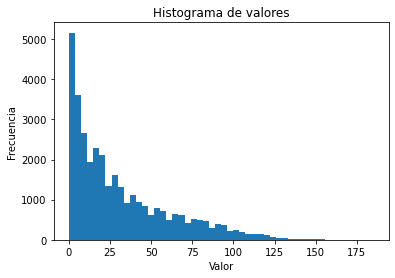

In [16]:
import matplotlib.pyplot as plt

plt.hist(data[cur_station], bins=50)
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma de valores')
plt.show()

In [17]:
columnas = data.columns
print(len(columnas))

2754


In [18]:
data_cols = [col for col in data.columns]
print(data_cols)

['U10_0_h0', 'U10_1_h0', 'U10_2_h0', 'U10_3_h0', 'U10_4_h0', 'U10_5_h0', 'U10_6_h0', 'U10_7_h0', 'U10_8_h0', 'U10_9_h0', 'U10_10_h0', 'U10_11_h0', 'U10_12_h0', 'U10_13_h0', 'U10_14_h0', 'U10_15_h0', 'V10_0_h0', 'V10_1_h0', 'V10_2_h0', 'V10_3_h0', 'V10_4_h0', 'V10_5_h0', 'V10_6_h0', 'V10_7_h0', 'V10_8_h0', 'V10_9_h0', 'V10_10_h0', 'V10_11_h0', 'V10_12_h0', 'V10_13_h0', 'V10_14_h0', 'V10_15_h0', 'RAINC_0_h0', 'RAINC_1_h0', 'RAINC_2_h0', 'RAINC_3_h0', 'RAINC_4_h0', 'RAINC_5_h0', 'RAINC_6_h0', 'RAINC_7_h0', 'RAINC_8_h0', 'RAINC_9_h0', 'RAINC_10_h0', 'RAINC_11_h0', 'RAINC_12_h0', 'RAINC_13_h0', 'RAINC_14_h0', 'RAINC_15_h0', 'T2_0_h0', 'T2_1_h0', 'T2_2_h0', 'T2_3_h0', 'T2_4_h0', 'T2_5_h0', 'T2_6_h0', 'T2_7_h0', 'T2_8_h0', 'T2_9_h0', 'T2_10_h0', 'T2_11_h0', 'T2_12_h0', 'T2_13_h0', 'T2_14_h0', 'T2_15_h0', 'RAINNC_0_h0', 'RAINNC_1_h0', 'RAINNC_2_h0', 'RAINNC_3_h0', 'RAINNC_4_h0', 'RAINNC_5_h0', 'RAINNC_6_h0', 'RAINNC_7_h0', 'RAINNC_8_h0', 'RAINNC_9_h0', 'RAINNC_10_h0', 'RAINNC_11_h0', 'RAINNC_1

Data shape: (34170, 2754) Data axes [Index(['2014-08-01 00:00:00', '2014-08-01 01:00:00', '2014-08-01 02:00:00',
       '2014-08-01 03:00:00', '2014-08-01 04:00:00', '2014-08-01 05:00:00',
       '2014-08-01 06:00:00', '2014-08-01 07:00:00', '2014-08-01 08:00:00',
       '2014-08-01 09:00:00',
       ...
       '2018-12-31 14:00:00', '2018-12-31 15:00:00', '2018-12-31 16:00:00',
       '2018-12-31 17:00:00', '2018-12-31 18:00:00', '2018-12-31 19:00:00',
       '2018-12-31 20:00:00', '2018-12-31 21:00:00', '2018-12-31 22:00:00',
       '2018-12-31 23:00:00'],
      dtype='object', name='fecha', length=34170), Index(['U10_0_h0', 'U10_1_h0', 'U10_2_h0', 'U10_3_h0', 'U10_4_h0', 'U10_5_h0',
       'U10_6_h0', 'U10_7_h0', 'U10_8_h0', 'U10_9_h0',
       ...
       'CCA_hm21', 'CCA_hm22', 'CCA_hm23', 'cont_pmdoscinco', 'cont_nox',
       'cont_co', 'cont_nodos', 'cont_no', 'cont_sodos', 'CCA'],
      dtype='object', length=2754)]
Done!
Normalizing data....


/tmp/ipykernel_2864423/2276559697.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{cur_station}"] = columna


Done!
Building X and Y ....
Pre bootstrap


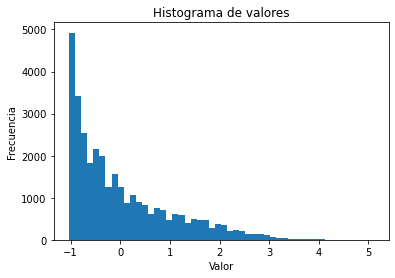

In [19]:
# Asegurar columna cur_station al final del DataFrame para normalización
columna = data.pop(f"{cur_station}")
data[f"{cur_station}"] = columna

config[ModelParams.INPUT_SIZE] = len(data.columns)
print(F'Data shape: {data.shape} Data axes {data.axes}')
print("Done!")

# Normalizar datos
print("Normalizing data....")
datetimes_str = data.index.values
datetimes = np.array([datetime.strptime(x, constants.datetime_format.value) for x in datetimes_str])

if norm_type == NormParams.min_max:
    scaler = preprocessing.MinMaxScaler()
if norm_type == NormParams.mean_zero:
    scaler = preprocessing.StandardScaler()

scaler = scaler.fit(data)
scaler_training = scaler
data_norm_np = scaler.transform(data)
data_norm_df = DataFrame(data_norm_np, columns=data.columns, index=data.index)
print(F'Done!')

# Filtrar fechas donde hay datos "forecasted hours after" (24 horas después)
print(F"Building X and Y ....")
accepted_times_idx = []
y_times_idx = []
for i, c_datetime in enumerate(datetimes):
    forecasted_datetime = (c_datetime + timedelta(hours=forecasted_hours))
    if forecasted_datetime in datetimes:
        accepted_times_idx.append(i)
        y_times_idx.append(np.argwhere(forecasted_datetime == datetimes)[0][0])

X_df = data_norm_df.loc[datetimes_str[accepted_times_idx]]
Y_df = data_norm_df.loc[datetimes_str[y_times_idx]][cur_station]
X = X_df.values
Y = Y_df.values

# Preparación previa al gráfico de histograma
print('Pre bootstrap')
import matplotlib.pyplot as plt

# Definir el índice de la columna a graficar
column_index = -1

plt.hist(X[:, column_index], bins=50)
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma de valores')
plt.show()


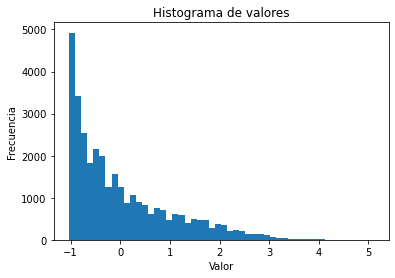

In [20]:
# Definir el índice de la columna a graficar último índice corresponde con cur_station
column_index = -1

plt.hist(X[:, column_index], bins=50)
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma de valores')
plt.show()

In [21]:
bootstrap = False
bootstrap_perc = 0
if perc_size > 0:
    bootstrap = True
    bootstrap_perc = perc_size

boostrap_factor = 15  # Number of times to repeat the bootstrap
percentiles = X_df[cur_station].quantile([bootstrap_perc])  # Obtain el percentil
print(percentiles) # target 2.3 ~ 90 ppm O_3

0.97    2.411069
Name: CCA, dtype: float64


Bootstrapping the data...
After bootstrap


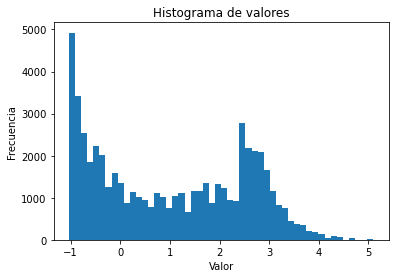

In [22]:
if bootstrap:
    # -------- Bootstrapping the data
    print("Bootstrapping the data...")
    percentiles = X_df[cur_station].quantile([bootstrap_perc])  # Obtain the percentile
    idxs_x = X[:,-1] > percentiles[bootstrap_perc]  # Obtain the indexes of the percentile for current time
    idxs_y = Y > percentiles[bootstrap_perc]  # Obtain the indexes of the percentile for the forecasted time
    idxs = idxs_y | idxs_x  # Merge both cases (we boostrap if the current time or the forecasted time are in the percentile)
    X_temp = X.copy()
    Y_temp = Y.copy()
    for i in range(boostrap_factor):
        X = np.concatenate((X, X_temp[idxs]))
        Y = np.concatenate((Y, Y_temp[idxs]))
        
import matplotlib.pyplot as plt

# Definir el índice de la columna a graficar
column_index = -1
print('After bootstrap')
plt.hist(X[:, column_index], bins=50)
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma de valores')
plt.show()

In [89]:
print("Done!")
print(F'X shape: {X.shape} Y shape: {Y.shape}')

tot_examples = X.shape[0]
rows_to_read = np.arange(tot_examples)

# store number of samples 4 train:
dataN4train = Y.shape[0]
print(f'Numero de samples para entrenamiento:{dataN4train}')

Done!
X shape: (7663, 2754) Y shape: (7663,)
Numero de samples para entrenamiento:7663


In [24]:
# Datos escalados:
data_norm_df

,U10_0_h0,U10_1_h0,U10_2_h0,U10_3_h0,U10_4_h0,U10_5_h0,U10_6_h0,U10_7_h0,U10_8_h0,U10_9_h0,...,CCA_hm21,CCA_hm22,CCA_hm23,cont_pmdoscinco,cont_nox,cont_co,cont_nodos,cont_no,cont_sodos,CCA
fecha,,,,,,,,,,,,,,,,,,,,,
2014-08-01 00:00:00,0.629865,0.660374,-0.650904,-0.610378,0.313802,-0.318473,-2.869622,-3.059905,-0.201725,-0.003567,...,-3.969324,-3.951422,-3.935763,-3.257891,0.161317,0.177507,0.280052,0.228402,0.053799,-0.871444
2014-08-01 01:00:00,0.381792,0.459288,0.988708,0.812574,-0.153690,0.688776,-0.179410,-1.071535,-0.675818,-1.342152,...,-3.969324,-3.951422,-3.935763,-3.257891,0.222259,0.177507,0.280052,0.297484,0.083634,-0.838287
2014-08-01 02:00:00,0.644041,1.146873,1.510877,1.231603,0.451824,1.226276,1.092987,0.104592,-0.870196,-1.342152,...,-3.969324,-3.951422,-3.935763,-3.257891,-0.033697,0.168863,0.104520,0.186953,0.053799,-0.141996
2014-08-01 03:00:00,0.587338,1.036600,1.751075,1.397468,0.723414,1.723125,1.645571,0.747888,0.281850,0.095181,...,-3.969324,-3.951422,-3.935763,-3.257891,-0.021509,0.168863,0.104520,0.186953,0.053799,-0.274623
2014-08-01 04:00:00,0.991344,0.679834,1.333340,1.196684,0.941578,1.696024,1.790988,1.131266,0.689570,0.654754,...,-3.969324,-3.951422,-3.935763,-3.257891,0.027245,0.171744,0.158530,0.200769,0.053799,-0.573033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.672392,-0.682361,-1.026866,0.367356,-0.322878,-0.765637,0.147777,1.144262,-1.159393,-0.914244,...,-0.133772,0.066231,0.156811,0.245340,0.271013,0.180388,0.442080,0.186953,0.143303,0.487981
2018-12-31 20:00:00,0.828324,-0.598035,-0.828442,0.384816,-0.273902,-0.770154,0.133236,1.144262,-1.225766,-1.084310,...,-0.205465,-0.130187,0.067842,0.554928,0.258825,0.183269,0.428578,0.186953,0.113469,-0.075683
2018-12-31 21:00:00,0.743271,-0.773174,-0.786668,0.332437,-0.313973,-0.878557,-0.070348,0.890843,-1.443849,-1.117226,...,-0.295080,-0.201612,-0.127890,0.424575,0.526970,0.189032,0.617611,0.297484,0.113469,-0.738817


In [25]:
print(X_df)
print('-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_')
print(Y_df)

                     U10_0_h0  U10_1_h0  U10_2_h0  U10_3_h0  U10_4_h0  \
fecha                                                                   
2014-08-01 00:00:00  0.629865  0.660374 -0.650904 -0.610378  0.313802   
2014-08-01 01:00:00  0.381792  0.459288  0.988708  0.812574 -0.153690   
2014-08-01 02:00:00  0.644041  1.146873  1.510877  1.231603  0.451824   
2014-08-01 03:00:00  0.587338  1.036600  1.751075  1.397468  0.723414   
2014-08-01 04:00:00  0.991344  0.679834  1.333340  1.196684  0.941578   
...                       ...       ...       ...       ...       ...   
2018-12-30 19:00:00  0.544812  0.121983  0.247227  0.873682  0.135710   
2018-12-30 20:00:00  0.785798  0.400908  0.832057  1.170494  0.331611   
2018-12-30 21:00:00  0.927554  0.679834  0.873831  1.013359  0.518608   
2018-12-30 22:00:00  0.977169  0.537128  0.466539  1.179224  0.580941   
2018-12-30 23:00:00  0.863764  0.238742  0.341218  1.022088  0.799104   

                     U10_5_h0  U10_6_h0  U10_7_h0 

In [26]:
print(X)
print('-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_')
print(Y)

[[ 0.62986543  0.66037419 -0.65090395 ...  0.2284021   0.05379931
  -0.87144352]
 [ 0.38179161  0.45928821  0.98870797 ...  0.297484    0.08363397
  -0.83828683]
 [ 0.64404108  1.14687251  1.51087737 ...  0.18695296  0.05379931
  -0.1419964 ]
 ...
 [ 0.16206909  0.04414297  0.27855758 ... -2.59013933  0.41181524
   3.20682901]
 [ 0.43140638 -0.53965502 -0.42114941 ... -2.59013933  0.41181524
   3.23998569]
 [ 0.27547426 -0.6823612  -0.60913039 ... -2.59013933  0.35214592
   3.00788888]]
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
[-0.07568303 -0.17515309 -0.00936965 ...  1.58215133  0.85270422
  0.58745072]


In [27]:
# ================ Split definition =================
[train_ids, val_ids, test_ids] = utilsNN.split_train_validation_and_test(tot_examples,
                                                                         val_percentage=val_perc,
                                                                         test_percentage=test_perc,
                                                                         shuffle_ids=False)

print("Train examples (total:{}) :{}".format(len(train_ids), rows_to_read[train_ids]))
print("Validation examples (total:{}) :{}:".format(len(val_ids), rows_to_read[val_ids]))
print("Test examples (total:{}) :{}".format(len(test_ids), rows_to_read[test_ids]))

now = datetime.utcnow().strftime("%Y_%m_%d_%H_%M")
model_name = F'{model_name_user}_{cur_pollutant}_{cur_station}_{now}'

print(f"Model Name :\n{model_name}")

Train examples (total:50404) :[    0     1     2 ... 50401 50402 50403]
Validation examples (total:5601) :[50404 50405 50406 ... 56002 56003 56004]:
Test examples (total:0) :[]
Model Name :
2023_CCA_0_97_t_t_cont_otres_CCA_2023_05_15_21_14


In [28]:
# # ================ Scaler training saving =================
import pickle

path_file = join(output_folder,F"{model_name}_scaler.pkl")

# Guarda el scaler en un archivo
with open(path_file, 'wb') as f:
    pickle.dump(scaler, f)

print(path_file)

/ZION/AirPollutionData/Data/Training/pmt-TE-2010-2018-v2019_r0v3_cmeteo_cboot_cr39/cont_otres_CCA/2023_CCA_0_97_t_t_cont_otres_CCA_2023_05_15_21_14_scaler.pkl


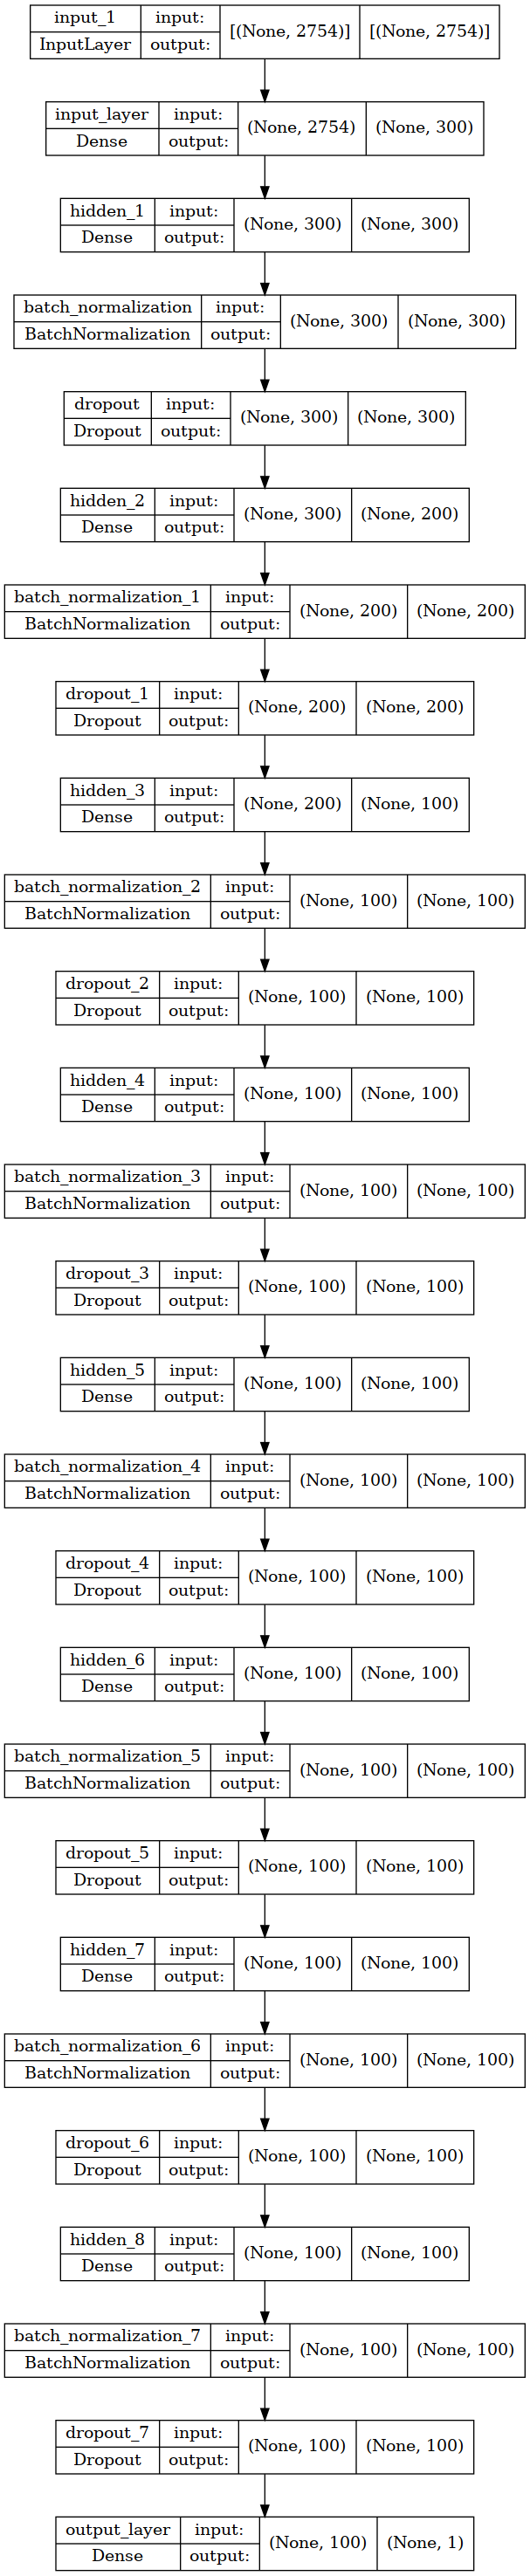

In [29]:
# ******************* Selecting the model **********************
model = select_1d_model(config)
plot_model(model, to_file=join(output_folder, F'{model_name}.png'), show_shapes=True)


In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2754)]            0         
                                                                 
 input_layer (Dense)         (None, 300)               826500    
                                                                 
 hidden_1 (Dense)            (None, 300)               90300     
                                                                 
 batch_normalization (BatchN  (None, 300)              1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hidden_2 (Dense)            (None, 200)               60200     
                                                             

Saving split information...
Norm params: {'copy': True, 'with_mean': True, 'with_std': True}
Saving normalization parameters....
Getting callbacks ...
The early stopping callback is in auto mode
Training setup ...


<Figure size 4608x576 with 0 Axes>

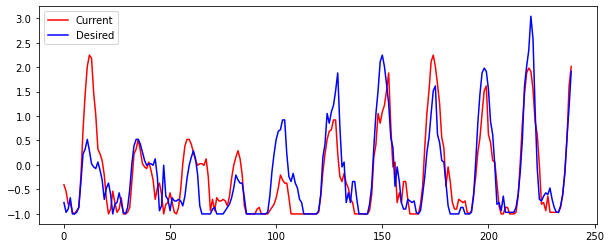

In [31]:
print("Saving split information...")

file_name_splits = join(split_info_folder, F'{model_name}.csv')
info_splits = DataFrame({F'Train({len(train_ids)})': train_ids})
info_splits[F'Validation({len(val_ids)})'] = 0
info_splits[F'Validation({len(val_ids)})'][0:len(val_ids)] = val_ids
info_splits[F'Test({len(test_ids)})'] = 0
info_splits[F'Test({len(test_ids)})'][0:len(test_ids)] = test_ids
info_splits.to_csv(file_name_splits, index=None)

print(F"Norm params: {scaler.get_params()}")
file_name_normparams = join(parameters_folder, F'{model_name}.csv')
utilsNN.save_norm_params(file_name_normparams, norm_type, scaler)
info_splits.to_csv(file_name_splits, index=None)

print("Getting callbacks ...")

[logger, save_callback, stop_callback] = utilsNN.get_all_callbacks(model_name=model_name,
                                                                   early_stopping_func=F'val_{eval_metrics[0].__name__}',
                                                                   weights_folder=weights_folder,
                                                                   logs_folder=logs_folder,patience=150)

print("Training setup ...")
# This part should be somehow separated, it will change for every project
x_train = X[train_ids, :]
y_train = Y[train_ids]
x_val = X[val_ids, :]
y_val = Y[val_ids]
x_test = X[test_ids, :]
y_test = Y[test_ids]

# ------------------- Plotting some intermediate results
size = 24 * 10 # 10 days of data
start = np.random.randint(0, len(data) - size)
end = start + size
plt.figure(figsize=[64, 8])
x_plot = range(len(X_df.iloc[start:end].index.values))
y_plot = X_df.iloc[start:end][cur_station].values
yy_plot = Y_df.iloc[start:end].values

fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(x_plot, y_plot, color='r', label='Current')
ax.plot(x_plot, yy_plot, color='b',  label='Desired')
ax.set_title = F"{cur_pollutant}_{cur_station}"
plt.legend()
plt.show()
# ------------------- Done Plotting some intermediate results


In [32]:
# Asignar el modelo existente a la variable model_1 dentro del bloque with strategy.scope()
with strategy.scope():
    model = select_1d_model(config)

    # Compilar el modelo    
    print("Compiling model ...")
    model.compile(loss=loss_func, optimizer=optimizer, metrics=eval_metrics)

    # Entrenar el modelo
    model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    shuffle=True,
                    callbacks=[logger, save_callback, stop_callback])


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2023-05-15 15:14:59.270143: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1905"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT

INFO:tensorflow:batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1
51/51 [==============================] - ETA: 0s - loss: 7.3387 - mean_squared_error: 7.3387

2023-05-15 15:15:08.867663: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_10931"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:34"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODU

51/51 [==============================] - 11s 67ms/step - loss: 7.3387 - mean_squared_error: 7.3387 - val_loss: 3.6085 - val_mean_squared_error: 3.6085
Epoch 2/5000
51/51 [==============================] - 1s 29ms/step - loss: 4.7227 - mean_squared_error: 4.7227 - val_loss: 3.1227 - val_mean_squared_error: 3.1227
Epoch 3/5000
51/51 [==============================] - 2s 31ms/step - loss: 3.6193 - mean_squared_error: 3.6193 - val_loss: 3.0501 - val_mean_squared_error: 3.0501
Epoch 4/5000
51/51 [==============================] - 2s 30ms/step - loss: 2.9662 - mean_squared_error: 2.9662 - val_loss: 2.8770 - val_mean_squared_error: 2.8770
Epoch 5/5000
51/51 [==============================] - 2s 30ms/step - loss: 2.6104 - mean_squared_error: 2.6104 - val_loss: 2.6543 - val_mean_squared_error: 2.6543
Epoch 6/5000
51/51 [==============================] - 2s 30ms/step - loss: 2.4101 - mean_squared_error: 2.4101 - val_loss: 2.4872 - val_mean_squared_error: 2.4872
Epoch 7/5000
51/51 [==============


KeyboardInterrupt



In [33]:
# Alarma de fin de entrenamiento XD
# *---------- sonido de alarma para sonar cuando se acaba el entrenamiento ----------*
import numpy as np
from IPython.display import Audio

# Definir la frecuencia del tono principal (880 Hz para La agudo)
freq1 = 880

# Crear una secuencia de muestras para el tono principal que dura 0.5 segundos
duration1 = 0.5 # segundos
sampling_rate = 44100 # Hz
t1 = np.linspace(0, duration1, int(duration1 * sampling_rate), False)
tones1 = np.sin(2 * np.pi * freq1 * t1)

# Definir la frecuencia del tono secundario (440 Hz para La)
freq2 = 440

# Crear una secuencia de muestras para el tono secundario que dura 0.5 segundos
duration2 = 0.5 # segundos
t2 = np.linspace(0, duration2, int(duration2 * sampling_rate), False)
tones2 = np.abs(np.mod(t2, 1./freq2)*freq2*2-1)-0.5

# Concatenar tres copias del arreglo de tonos
tones = np.concatenate((tones1, tones2), axis=None)
tones = np.concatenate((tones, tones, tones), axis=None)

# Reproducir el sonido de timbre tres veces
Audio(tones, rate=sampling_rate, autoplay=True)

# ---------- Fin de alarma

In [34]:
print(loss_func)
print(optimizer)
print(eval_metrics)

<function mean_squared_error at 0x7f7380494ee0>
[<function mean_squared_error at 0x7f7380494ee0>]


In [35]:
model

# Evaluation

In [136]:
import tensorflow as tf
import tensorflow.keras.metrics as metrics
import tensorflow.keras.losses as losses
from tensorflow.keras.optimizers import *
from ai_common.constants.AI_params import ModelParams, AiModels, TrainingParams, ClassificationParams, VisualizationResultsParams, NormParams


def select_available_gpus(num_gpus, memory_limit=7168):
    # Obtener la lista de todas las GPUs disponibles
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        return []
    
    # Seleccionar las primeras 'num_gpus' GPUs
    selected_gpus = gpus[:num_gpus]
    
    # Configurar TensorFlow para usar las GPUs seleccionadas
    try:
        tf.config.experimental.set_visible_devices(selected_gpus, 'GPU')
        for gpu in selected_gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
            tf.config.experimental.set_memory_growth(gpu, True)
        return selected_gpus
    except RuntimeError as e:
        print(e)
        return []

try:
    #selected_gpus = select_available_gpus(2)
    #print(f"Se han seleccionado {len(selected_gpus)} GPUs con 7.375 GB de memoria cada una.")
    # Configuración de la estrategia de distribución en GPUs
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

except ValueError as e:
    print(e)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


import sys
sys.path.append('/home/pedro/git2/otro2/air_pollution_forecast/eoas_pyutils')
sys.path.append('/home/pedro/git2/otro2/air_pollution_forecast/')

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from os.path import join
from datetime import date, datetime, timedelta
from sklearn import preprocessing

import scrapbook as sb
from ai_common.constants.AI_params import NormParams, TrainingParams, ModelParams
import ai_common.training.trainingutils as utilsNN
from ai_common.models.modelSelector import select_1d_model
from viz_utils.eoa_viz import EOAImageVisualizer
from io_utils.io_common import create_folder
from conf.localConstants import constants
from conf.TrainingUserConfiguration import getTrainingParams
from conf.params import LocalTrainingParams


# Function definitions

def select_available_gpus(num_gpus, memory_limit=7168):
    # Obtener la lista de todas las GPUs disponibles
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        return []
    
    # Seleccionar las primeras 'num_gpus' GPUs
    selected_gpus = gpus[:num_gpus]
    
    # Configurar TensorFlow para usar las GPUs seleccionadas
    try:
        tf.config.experimental.set_visible_devices(selected_gpus, 'GPU')
        for gpu in selected_gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
            tf.config.experimental.set_memory_growth(gpu, True)
        return selected_gpus
    except RuntimeError as e:
        print(e)
        return []
    

def append_model_params(cur_config):
    model_config = {
        ModelParams.MODEL: AiModels.ML_PERCEPTRON,
        ModelParams.DROPOUT: True,
        ModelParams.BATCH_NORMALIZATION: True,
        #ModelParams.CELLS_PER_HIDDEN_LAYER: [300, 50],
        # ModelParams.CELLS_PER_HIDDEN_LAYER: [300, 300, 300],
        ModelParams.CELLS_PER_HIDDEN_LAYER: [300, 300, 200, 100, 100, 100, 100, 100, 100],
        ModelParams.NUMBER_OF_OUTPUT_CLASSES: 1,
        ModelParams.ACTIVATION_HIDDEN_LAYERS: 'relu',
        ModelParams.ACTIVATION_OUTPUT_LAYERS: None
    }
    model_config[ModelParams.HIDDEN_LAYERS] = len(model_config[ModelParams.CELLS_PER_HIDDEN_LAYER])
    return {**cur_config, **model_config}

def getTrainingParams2():
    cur_config = {
        TrainingParams.input_folder: join(data_folder, constants.merge_output_folder.value, merged_specific_folder),
        TrainingParams.output_folder: F"{join(data_folder, constants.training_output_folder.value,f'{test_str}')}",        
        TrainingParams.validation_percentage: .1,
        TrainingParams.test_percentage: 0, # We will test with a diferent day
        TrainingParams.evaluation_metrics: [metrics.mean_squared_error],  # Metrics to show in tensor flow in the training
        TrainingParams.loss_function: losses.mean_squared_error,  # Loss function to use for the learning
        
        #TrainingParams.evaluation_metrics: [metrics.mean_squared_logarithmic_error], #mean_squared_error],  # Metrics to show in tensor flow in the training
        #TrainingParams.loss_function: losses.mean_squared_logarithmic_error, # PS_test:losses.mean_squared_error,  # Loss function to use for the learning

        # TrainingParams.loss_function: metrics.mean_squared_error,  # Loss function to use for the learning
        TrainingParams.optimizer: Adam(), #learning_rate=0.0005,beta_1=0.99,beta_2=0.999,epsilon=1e-07),#),  # Default values lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None,
        TrainingParams.batch_size: batch_size, #200,
        TrainingParams.epochs: 5000,
        TrainingParams.config_name: _run_name,
        TrainingParams.data_augmentation: False,
        TrainingParams.normalization_type: NormParams.mean_zero,
        LocalTrainingParams.stations: stations_2020,
        LocalTrainingParams.pollutants: ["cont_otres"],
        LocalTrainingParams.forecasted_hours: 24,
        LocalTrainingParams.tot_num_quadrants: 64,  # 8x8
        LocalTrainingParams.num_hours_in_netcdf: 24,
        LocalTrainingParams.years: range(start_year, end_year),
        LocalTrainingParams.debug: _debug,
        LocalTrainingParams.filter_dates: filter_training_hours
    }
    return append_model_params(cur_config)

# Variable definitions
data_folder = '/ZION/AirPollutionData/Data/'
grid_size = 4
merged_specific_folder = f'{grid_size*grid_size}'
_run_name = F'2023_{test_identifier}'
stations_2020 = ["UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM", "IZT", "CCA", "HGM", "LPR",
                 "MGH", "CAM", "FAC", "TLA", "MER", "XAL", "LLA", "TLI", "UAX", "BJU", "MPA",
                 "MON", "NEZ", "INN", "AJM", "VIF"]
_debug = False
filter_training_hours = False
start_year = 2010
end_year = 2018
cur_pollutant = 'cont_otres'
all_stations = ["UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM", "IZT", "CCA", "HGM", "LPR",
                "MGH", "CAM", "FAC", "TLA", "MER", "XAL", "LLA", "TLI", "UAX", "BJU", "MPA",
                "MON", "NEZ", "INN", "AJM", "VIF"]
test_year = 2019

# TensorFlow configuration
try:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
except ValueError as e:
    print(e)

# Load configuration and print values
config = getTrainingParams2()
stations = ['UIZ', 'CUA', 'PED', 'CCA']
pollutants = config[LocalTrainingParams.pollutants]


print("config values:\n")
for key, value in config.items():
    print(f"{key} : {value}")

print(f"""

stations: {stations}

pollutants: {pollutants}

start_year: {start_year}

end_year: {end_year}
""")

In [137]:
#config[ModelParams.INPUT_SIZE] = 2756 # len(data.columns)
#forecasted_hours = 24
#model = select_1d_model(config)


In [138]:
## Para usar en caso de recargado del modelo, revisar los siguientes datos:
#path_file = '/ZION/AirPollutionData/Data/Training/pmt-TE-2010-2018-v2019_r0v3_cr34/cont_otres_MER/2023_MER_0_97_t_t_cont_otres_MER_2023_05_02_16_16_scaler.pkl'
#model_name = '2023_MER_0_97_t_t_cont_otres_MER_2023_05_02_16_16'
#output_folder = '/ZION/AirPollutionData/Data/Training/pmt-TE-2010-2018-v2019_r0v3_cr34/cont_otres_MER/'

In [139]:
data_folder = '/ZION/AirPollutionData/Data/MergedDataCSV/16/'
input_file = join(data_folder,f"{test_year}_cont_otres_AllStations.csv")
data = pd.read_csv(input_file, index_col=0)
# -------- Removing not used stations
#remove_columns = [x for x in all_stations if x.find(cur_station) == -1]
#data = data.drop(columns=remove_columns)
# -------- Remove nans

In [140]:
# Remove meteo ?
import re
if not meteo_vars:
    regex_list = ['U10.*', 'V10.*','RAINC.*', 'T2.*', 'RAINNC.*', 'SWDOWN.*', 'GLW.*']
    filtered_data = data.filter(regex='^(?!(%s)).*$' % '|'.join(regex_list))
    print(filtered_data)
    data = filtered_data

In [141]:
remove_columns = [x for x in all_stations if x.find(cur_station) == -1]
data.loc[:,remove_columns] = data.loc[:,remove_columns].fillna(-200)
data = data.dropna()

# Se agregan las ultimas 23 horas de contaminantes al dataset como hm1 -> menos 1hr, ...
# Iteramos sobre el DataFrame usando iterrows()
for index, row in data.iterrows():
    #print(index, row['TLA'])
    dt_row = datetime.strptime(index, constants.datetime_format.value)
    for i in range(24):
        dt_target = dt_row - timedelta(hours=i)
        dt_target_str = dt_target.strftime('%Y-%m-%d %H:%M:%S')
        if dt_target_str in data.index:
            temp_val = data.loc[dt_target_str][f'{cur_station}']
        else:
            temp_val = np.nan
        data.loc[f'{index}', f'{cur_station}_hm{i}'] = temp_val

# moviendo columna cur_station al final del data frame para considerarlo asi en normalizacion scaler
columna = data.pop(f"{cur_station}")
data[f"{cur_station}"] = columna
#data.pop(f"{cur_station}_hm0") # Se remueve datos repetidos en cur_station


data = data.fillna(-200)

# concatenar columnas contaminantes
import pandas as pd
import glob
import re

def load_dataframes(input_folder, regex):
    file_names = glob.glob(input_folder + "/*")
    dataframes = {}
    
    for file_name in file_names:
        match = re.search(regex, file_name)
        
        if match:
            key = match.group(1)
            df = pd.read_csv(file_name, index_col=0)
            df = df.loc['2010-01-01':]
            df = df[~df.index.duplicated()]
            
            if key == 'otres_':
                continue
            
            if key in dataframes:
                dataframes[key] = pd.concat([dataframes[key], df], axis=1)
            else:
                dataframes[key] = df
                
    return dataframes

input_folder = "/ZION/AirPollutionData/Data/DataPollutionDB_CSV"
regex = f"cont_(.*?){cur_station}\.csv"

print(f'Buscando con la expresión regular: {regex}')

dataframes = load_dataframes(input_folder, regex)
data_cont = pd.concat(dataframes.values(), axis=1)
data_cont = data_cont[~data_cont.index.duplicated()]
data_cont.fillna(-200)


# Seleccionar todas las columnas de data_cont
data_cont_cols = data_cont.columns

# Concatenar todas las columnas de data_cont con data
data = pd.concat([data, data_cont[data_cont_cols]], axis=1)
#data = data.dropna()
data = data.dropna(subset=[cur_station])
data.fillna(-200, inplace=True)
# moviendo columna cur_station al final del data frame para considerarlo asi en normalizacion scaler
columna = data.pop(f"{cur_station}")
data[f"{cur_station}"] = columna
###

# moviendo columna cur_station al final del data frame para considerarlo asi en normalizacion scaler
columna = data.pop(f"{cur_station}")
data[f"{cur_station}"] = columna
###

config[ModelParams.INPUT_SIZE] = len(data.columns)
print(F'Data shape: {data.shape} Data axes {data.axes}')
print("Done!")

# Predicting for the next value after 24hrs (only one)
print("Normalizing data....")
# TODO we need to normalize by reading the parameters from the training
# norm_file = "/data/PollutionData/Training/Parameters/2023_cont_otres_UIZ_2023_02_14_21_19.csv"
datetimes_str = data.index.values
datetimes = np.array([datetime.strptime(x, constants.datetime_format.value) for x in datetimes_str])
scaler = None

#scaler = preprocessing.MinMaxScaler()
#scaler = scaler.fit(data)
#scaler = scaler_training  # <- Para corregir escalamiento.

import pickle

#path_file = join(output_folder,F"scaler.pkl")
#path_file = join(output_folder,F"{model_name}_scaler.pkl")

print(path_file)
# Guarda el scaler en un archivo
#with open(path_file, 'wb') as f:
#    pickle.dump(scaler, f)


# Carga el scaler desde un archivo
with open(path_file, 'rb') as f:
    scaler = pickle.load(f)

data_norm_np = scaler.transform(data)
data_norm_df = pd.DataFrame(data_norm_np, columns=data.columns, index=data.index)
print(F'Done!')

# Filtering only dates where there is data "forecasted hours after" (24 hrs after)
print(F"\tBuilding X and Y ....")
accepted_times_idx = []
y_times_idx = []
for i, c_datetime in enumerate(datetimes):
    forecasted_datetime = (c_datetime + timedelta(hours=forecasted_hours))
    if forecasted_datetime in datetimes:
        accepted_times_idx.append(i)
        y_times_idx.append(np.argwhere(forecasted_datetime == datetimes)[0][0])

X_df = data_norm_df.loc[datetimes_str[accepted_times_idx]]
Y_df = data_norm_df.loc[datetimes_str[y_times_idx]][cur_station]
X = X_df.values
Y = Y_df.values

print(F'X shape: {X.shape} Y shape: {Y.shape}')

/tmp/ipykernel_2864423/4038635294.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{cur_station}"] = columna


Buscando con la expresión regular: cont_(.*?)CCA\.csv


/tmp/ipykernel_2864423/4038635294.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{cur_station}"] = columna
/tmp/ipykernel_2864423/4038635294.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{cur_station}"] = columna


Data shape: (8089, 2754) Data axes [Index(['2019-01-01 03:00:00', '2019-01-01 04:00:00', '2019-01-01 05:00:00',
       '2019-01-01 06:00:00', '2019-01-01 07:00:00', '2019-01-01 08:00:00',
       '2019-01-01 09:00:00', '2019-01-01 10:00:00', '2019-01-01 11:00:00',
       '2019-01-01 12:00:00',
       ...
       '2019-12-30 15:00:00', '2019-12-30 16:00:00', '2019-12-30 17:00:00',
       '2019-12-30 18:00:00', '2019-12-30 19:00:00', '2019-12-30 20:00:00',
       '2019-12-30 21:00:00', '2019-12-30 22:00:00', '2019-12-30 23:00:00',
       '2019-12-31 00:00:00'],
      dtype='object', name='fecha', length=8089), Index(['U10_0_h0', 'U10_1_h0', 'U10_2_h0', 'U10_3_h0', 'U10_4_h0', 'U10_5_h0',
       'U10_6_h0', 'U10_7_h0', 'U10_8_h0', 'U10_9_h0',
       ...
       'CCA_hm21', 'CCA_hm22', 'CCA_hm23', 'cont_pmdoscinco', 'cont_nox',
       'cont_co', 'cont_nodos', 'cont_no', 'cont_sodos', 'CCA'],
      dtype='object', length=2754)]
Done!
Normalizing data....
/ZION/AirPollutionData/Data/Training/pm

In [142]:
data

,U10_0_h0,U10_1_h0,U10_2_h0,U10_3_h0,U10_4_h0,U10_5_h0,U10_6_h0,U10_7_h0,U10_8_h0,U10_9_h0,...,CCA_hm21,CCA_hm22,CCA_hm23,cont_pmdoscinco,cont_nox,cont_co,cont_nodos,cont_no,cont_sodos,CCA
fecha,,,,,,,,,,,,,,,,,,,,,
2019-01-01 03:00:00,-1.98,1.02,1.01,-0.91,0.49,0.68,-0.49,-2.29,1.55,1.94,...,-200.0,-200.0,-200.0,84.0,51.0,1.40,31.0,20.0,2.0,5.0
2019-01-01 04:00:00,-1.90,0.85,0.79,-0.83,0.03,0.49,-0.97,-2.98,1.92,1.89,...,-200.0,-200.0,-200.0,95.0,51.0,1.40,31.0,20.0,2.0,5.0
2019-01-01 05:00:00,-1.77,1.11,1.01,-1.02,-0.28,0.75,-0.98,-3.67,1.31,2.13,...,-200.0,-200.0,-200.0,97.0,44.0,1.20,27.0,16.0,2.0,5.0
2019-01-01 06:00:00,-0.82,1.86,1.03,-1.11,0.66,1.13,-0.77,-3.69,1.52,2.17,...,-200.0,-200.0,-200.0,88.0,32.0,0.90,25.0,7.0,2.0,5.0
2019-01-01 07:00:00,-0.36,2.42,1.90,-0.22,1.28,0.96,-0.84,-2.98,1.09,1.33,...,-200.0,-200.0,-200.0,77.0,24.0,0.70,20.0,4.0,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 20:00:00,1.75,1.56,0.60,-0.22,0.53,-0.48,-0.76,0.43,-0.44,-0.42,...,4.0,4.0,6.0,14.0,27.0,0.42,22.0,4.0,1.0,16.0
2019-12-30 21:00:00,1.42,1.16,0.56,-0.57,0.32,0.03,-1.28,-0.00,-0.21,-0.05,...,4.0,4.0,4.0,11.0,29.0,0.51,27.0,2.0,1.0,13.0
2019-12-30 22:00:00,1.09,1.09,0.66,-0.20,0.57,0.31,-1.69,0.02,0.46,-0.06,...,5.0,4.0,4.0,14.0,42.0,0.61,28.0,13.0,1.0,5.0


In [143]:
# Asumiendo que tu DataFrame se llama 'data'
column_names = data.columns

# Imprime el nombre de las columnas y su índice
for index, column_name in enumerate(column_names):
    print(f"Índice: {index}, Nombre de columna: {column_name}")

# Convierte el DataFrame a un NumPy array
numpy_array = data.to_numpy()


Índice: 0, Nombre de columna: U10_0_h0
Índice: 1, Nombre de columna: U10_1_h0
Índice: 2, Nombre de columna: U10_2_h0
Índice: 3, Nombre de columna: U10_3_h0
Índice: 4, Nombre de columna: U10_4_h0
Índice: 5, Nombre de columna: U10_5_h0
Índice: 6, Nombre de columna: U10_6_h0
Índice: 7, Nombre de columna: U10_7_h0
Índice: 8, Nombre de columna: U10_8_h0
Índice: 9, Nombre de columna: U10_9_h0
Índice: 10, Nombre de columna: U10_10_h0
Índice: 11, Nombre de columna: U10_11_h0
Índice: 12, Nombre de columna: U10_12_h0
Índice: 13, Nombre de columna: U10_13_h0
Índice: 14, Nombre de columna: U10_14_h0
Índice: 15, Nombre de columna: U10_15_h0
Índice: 16, Nombre de columna: V10_0_h0
Índice: 17, Nombre de columna: V10_1_h0
Índice: 18, Nombre de columna: V10_2_h0
Índice: 19, Nombre de columna: V10_3_h0
Índice: 20, Nombre de columna: V10_4_h0
Índice: 21, Nombre de columna: V10_5_h0
Índice: 22, Nombre de columna: V10_6_h0
Índice: 23, Nombre de columna: V10_7_h0
Índice: 24, Nombre de columna: V10_8_h0
Índi

In [144]:
data_norm_df

,U10_0_h0,U10_1_h0,U10_2_h0,U10_3_h0,U10_4_h0,U10_5_h0,U10_6_h0,U10_7_h0,U10_8_h0,U10_9_h0,...,CCA_hm21,CCA_hm22,CCA_hm23,cont_pmdoscinco,cont_nox,cont_co,cont_nodos,cont_no,cont_sodos,CCA
fecha,,,,,,,,,,,,,,,,,,,,,
2019-01-01 03:00:00,-1.212969,0.426855,0.727623,-0.828622,0.006593,0.133208,0.118694,-1.026050,0.395632,0.950998,...,-3.969324,-3.951422,-3.935763,1.369633,0.502593,0.200557,0.442080,0.449464,0.113469,-0.871444
2019-01-01 04:00:00,-1.156266,0.316582,0.497869,-0.758784,-0.198213,0.047389,-0.230306,-1.474408,0.571047,0.923568,...,-3.969324,-3.951422,-3.935763,1.548868,0.502593,0.200557,0.442080,0.449464,0.113469,-0.871444
2019-01-01 05:00:00,-1.064124,0.485235,0.727623,-0.924649,-0.336235,0.164826,-0.237577,-1.922766,0.281850,1.055232,...,-3.969324,-3.951422,-3.935763,1.581456,0.417274,0.194794,0.388071,0.394199,0.113469,-0.871444
2019-01-01 06:00:00,-0.390781,0.971733,0.748510,-1.003217,0.082282,0.336464,-0.084889,-1.935762,0.381409,1.077177,...,-3.969324,-3.951422,-3.935763,1.434809,0.271013,0.186150,0.361066,0.269851,0.113469,-0.871444
2019-01-01 07:00:00,-0.064741,1.334985,1.657085,-0.226268,0.358325,0.259679,-0.135785,-1.474408,0.177549,0.616352,...,-3.969324,-3.951422,-3.935763,1.255574,0.173506,0.180388,0.293554,0.228402,0.113469,-0.771973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 20:00:00,1.430789,0.777134,0.299444,-0.226268,0.024402,-0.390742,-0.077619,0.741390,-0.547813,-0.343699,...,-0.313003,-0.308750,-0.270240,0.229046,0.210071,0.172320,0.320559,0.228402,0.083634,-0.506720
2019-12-30 21:00:00,1.196891,0.517668,0.257671,-0.531810,-0.069096,-0.160385,-0.455702,0.461978,-0.438772,-0.140717,...,-0.313003,-0.308750,-0.305828,0.180164,0.234448,0.174914,0.388071,0.200769,0.083634,-0.606190
2019-12-30 22:00:00,0.962993,0.472261,0.362105,-0.208808,0.042211,-0.033914,-0.753807,0.474974,-0.121129,-0.146203,...,-0.295080,-0.308750,-0.305828,0.229046,0.392897,0.177795,0.401573,0.352750,0.083634,-0.871444


import pandas as pd

# Asumiendo que tu DataFrame se llama 'data'

# Lista de variables a considerar
variables = ['U10', 'V10', 'RAINC','RAINNC', 'GLW', 'SWDOWN']

# Encuentra las columnas que contienen 'h0' para cada variable y calcula el promedio
for var in variables:
    columnas_h23 = [col for col in data.columns if f'{var}_' in col and '_h23' in col]
    promedio_h23 = data[columnas_h23].mean(axis=1)
    data[f'{var}_prom_h23'] = promedio_h23

# Muestra el DataFrame actualizado con las nuevas columnas de promedios
print(data)

In [145]:
# Loading the best weight file 
import glob
path_model_weights = join(f'{output_folder}',f'models')
print(path_model_weights)
model_weights_file = join(path_model_weights,f'{model_name}*')
weight_files = glob.glob(model_weights_file)
lista_weights =[]
for item in weight_files:
    lista_weights.append(float(item.split('/')[-1].split('-')[-1].split('.hdf5')[0]))
print(lista_weights)
model_weights_file = glob.glob(join(path_model_weights,f'{model_name}*{min(lista_weights)}*'))
model_weights_file = model_weights_file[0]
print(f'\nModel weight file to use of    {min(lista_weights)}: \n\n',model_weights_file)


/ZION/AirPollutionData/Data/Training/pmt-TE-2010-2018-v2019_r0v3_cmeteo_cboot_cr39/cont_otres_CCA/models
[3.6085422, 3.12268829, 3.05009437, 2.87700295, 2.65429139, 2.48723507, 2.34223104, 2.17389917, 2.05175304, 1.83365107, 1.79824996, 1.63411701, 1.43796861, 1.17617691, 1.02986157, 0.98303097, 0.92542088, 0.90479589, 0.87292492, 0.86759007, 0.86039156, 0.83828133, 0.83821303, 0.80705029, 0.77204543, 0.74900532, 0.71827823, 0.68435115, 0.6629805, 0.66084313, 0.65698111, 0.63275093, 0.6232003, 0.61960417, 0.60639513, 0.59609932, 0.59134889, 0.59050298, 0.57588226, 0.56363088, 0.53421623, 0.53292507, 0.51582325, 0.50327599, 0.47765145, 0.45654821, 0.44722542, 0.41178373, 0.40886438, 0.37702721, 0.37370512, 0.37220278, 0.35129327, 0.3371194, 0.32998061, 0.30298433, 0.29644582, 0.28902879, 0.27159008, 0.25227463, 0.24080549, 0.21880932, 0.21606351, 0.2088754, 0.20721069, 0.19746736, 0.18404263, 0.15903769, 0.15325536, 0.13660984, 0.11517659, 0.0970731, 0.08937361, 0.07302226, 0.0721228, 0

In [146]:
import sys
sys.path.append('./eoas_pyutils')

from datetime import date, datetime, timedelta

from viz_utils.eoa_viz import EOAImageVisualizer
from sklearn import preprocessing
from conf.localConstants import constants
from pandas import DataFrame
import pandas as pd
import time
from ai_common.constants.AI_params import *
from os.path import join
from conf.params import LocalTrainingParams

from conf.TrainingUserConfiguration import get_makeprediction_config
from io_utils.io_common import  create_folder
from AI.data_generation.utilsDataFormat import *
from ai_common.models.modelSelector import select_1d_model
from os import listdir
import glob
import os

# *********** Chooses the proper model ***********
#print('Reading model ....')
#model = select_1d_model(config)

# *********** Reads the weights***********
print('Reading weights ....')
model.load_weights(model_weights_file)

#create_folder(output_folder)
#create_folder(output_imgs_folder)
from conf.TrainingUserConfiguration import get_makeprediction_config
config = get_makeprediction_config()


Reading weights ....


In [147]:
print(config)
# *********** Makes a dataframe to contain the DSC information **********
metrics_dict = config[ClassificationParams.metrics]


{<ClassificationParams.input_file: 19>: '/ZION/AirPollutionData/Data/MergedDataCSV/16/2015_cont_otres_AllStations.csv', <ClassificationParams.output_folder: 2>: '/ZION/AirPollutionData/Data/Results', <ClassificationParams.model_weights_file: 8>: '/ZION/AirPollutionData/Training/models', <ClassificationParams.split_file: 30>: '', <ClassificationParams.output_file_name: 4>: '/ZION/AirPollutionData/Training/Results/2023.csv', <ClassificationParams.output_imgs_folder: 3>: '/ZION/AirPollutionData/Data/Results/2023', <ClassificationParams.generate_images: 22>: False, <ClassificationParams.show_imgs: 5>: False, <ClassificationParams.save_prediction: 21>: True, <LocalTrainingParams.stations: 2>: ['UIZ', 'AJU', 'ATI', 'CUA', 'SFE', 'SAG', 'CUT', 'PED', 'TAH', 'GAM', 'IZT', 'CCA', 'HGM', 'LPR', 'MGH', 'CAM', 'FAC', 'TLA', 'MER', 'XAL', 'LLA', 'TLI', 'UAX', 'BJU', 'MPA', 'MON', 'NEZ', 'INN', 'AJM', 'VIF'], <LocalTrainingParams.pollutants: 1>: ['otres'], <LocalTrainingParams.forecasted_hours: 7>: 

 16/240 [=>............................] - ETA: 0s 

2023-05-15 15:58:09.944657: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_169486"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3780"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

240/240 [==============================] - 1s 5ms/step


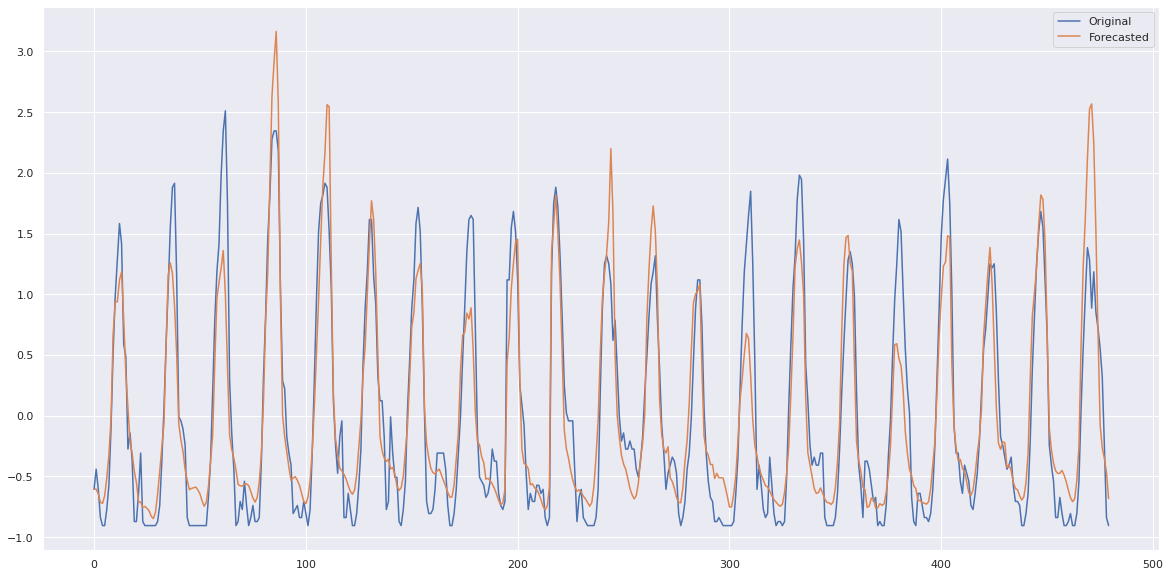

	 Done! Elapsed time 2.06 seg


In [148]:

# *********** Iterates over each case *********
t0 = time.time()
# -------------------- Reading data -------------
output_nn_all = model.predict(X, verbose=1)

# Plotting some intermediate results
import matplotlib.pyplot as plt
size = 24 * 10  # Two months of data
start = np.random.randint(0, len(data) - size)
end = start + size
#plt.figure(figsize=[64, 8])
plt.figure(figsize=[20, 10])
x_plot = range(len(Y))
y_plot = Y
u_plot = X
yy_plot = Y_df.iloc[start:end].values
plot_this_many= 24*20
plt.plot(x_plot[0:plot_this_many], y_plot[0:plot_this_many], label='Original')
plt.plot(x_plot[0:plot_this_many], output_nn_all[0:plot_this_many,0], label='Forecasted')
plt.legend()
plt.show()

print(F'\t Done! Elapsed time {time.time() - t0:0.2f} seg')


In [149]:
X2_df = data.loc[datetimes_str[accepted_times_idx]]
Y2_df = data.loc[datetimes_str[y_times_idx]][cur_station]
X2 = X2_df.values
Y2 = Y2_df.values

# Asumiendo que tu array se llama X:
U10_0_h0_column = X2[:, -6]
V10_0_h0_column = X2[:, -5]
RAIN_0_h0_column = X2[:, -4]/10
RAINNC_0_h0_column = X2[:, -3]/10
SWDOWN_0_h0_column = X2[:, -1]/800
GLW_0_h0_column = X2[:, -2]/200
# Estaciones contaminantes
# Asumiendo que tu array se llama X
idx_sta0 = 2694

In [150]:
# Estaciones contaminantes
# Asumiendo que tu array se llama X
idx_sta0 = 0#len(X[0, :]) - 2

# Crear una lista vacía para almacenar las columnas de las estaciones
o3_columns = []
num_stations = 12
# Obtener las columnas para las estaciones 0 a 11
for i in range(num_stations):
    idx = idx_sta0 + i
    o3_column = X[:, idx]
    o3_columns.append(o3_column)

# Ahora, o3_columns contiene las columnas para las estaciones 0 a 11
# o3_columns[0] corresponde a o3_sta0_column, o3_columns[1] corresponde a o3_sta1_column, etc.


#print(U10_0_h0_column)

 16/240 [=>............................] - ETA: 0s 

2023-05-15 15:58:12.275649: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_170627"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3807"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

240/240 [==============================] - 1s 5ms/step


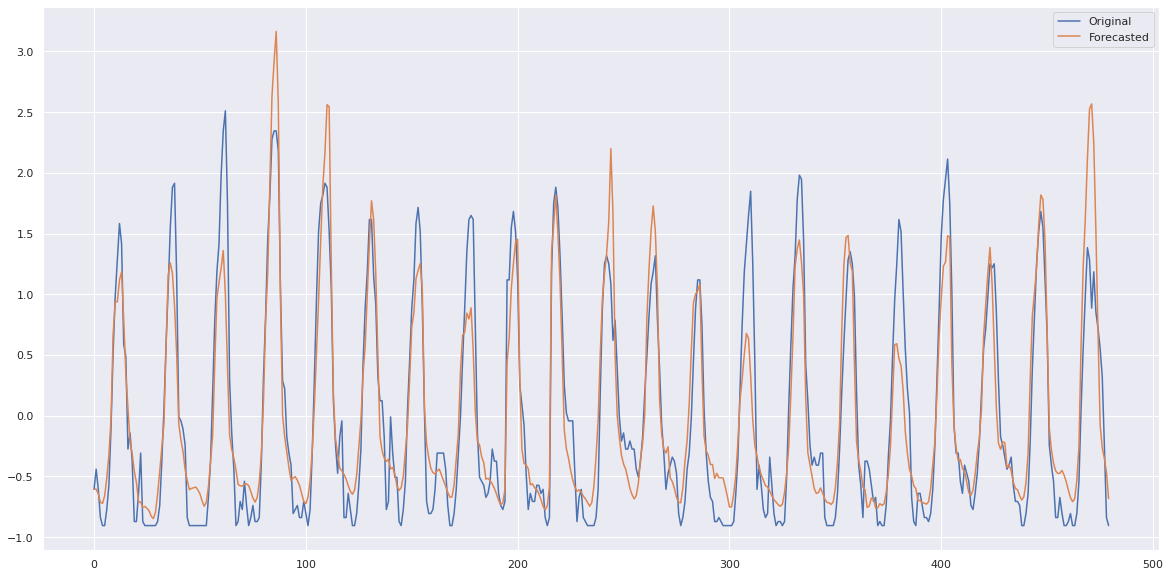

	 Done! Elapsed time 2.05 seg


In [151]:
# Calculate the absolute value of the wind
#wind_abs = np.sqrt(np.array(U10_0_h0_column)**2 + np.array(V10_0_h0_column)**2)

# *********** Iterates over each case *********
t0 = time.time()
# -------------------- Reading data -------------
output_nn_all = model.predict(X, verbose=1)

# Plotting some intermediate results
import matplotlib.pyplot as plt
size = 24 * 10  # Two months of data
start = np.random.randint(0, len(data) - size)
end = start + size
#plt.figure(figsize=[64, 8])
plt.figure(figsize=[20, 10])
x_plot = range(len(Y))
y_plot = Y
yy_plot = Y_df.iloc[start:end].values
plot_this_many= 24*20
plt.plot(x_plot[0:plot_this_many], y_plot[0:plot_this_many], label='Original')
plt.plot(x_plot[0:plot_this_many], output_nn_all[0:plot_this_many,0], label='Forecasted')

#factor_wind = 1.0
#plt.plot(x_plot[0:plot_this_many], factor_wind*U10_0_h0_column[0:plot_this_many], linestyle='--', label='U10_0_h0_column')
#plt.plot(x_plot[0:plot_this_many], factor_wind*V10_0_h0_column[0:plot_this_many], linestyle='--',label='V10_0_h0_column')
#plt.plot(x_plot[0:plot_this_many], factor_wind * wind_abs[0:plot_this_many], linestyle='--', label='Wind Abs')

factor_rain = 20
#plt.plot(x_plot[0:plot_this_many], factor_rain*RAIN_0_h0_column[0:plot_this_many], linestyle='-',label='RAIN_0_h0_column')
#plt.plot(x_plot[0:plot_this_many], factor_rain*RAINNC_0_h0_column[0:plot_this_many], linestyle='-',label='RAINNC_0_h0_column')
factor_swdown = 1
#plt.plot(x_plot[0:plot_this_many], factor_swdown*SWDOWN_0_h0_column[0:plot_this_many], linestyle=':',label='SWDOWN_0_h0_column')
factor_glw = 1
#plt.plot(x_plot[0:plot_this_many], factor_glw*GLW_0_h0_column[0:plot_this_many], linestyle=':',label='GLW_0_h0_column')

#factor_stations = 1
# Asumiendo que 'o3_columns' contiene las columnas de las estaciones
#for i, o3_column in enumerate(o3_columns):
#    plt.plot(x_plot[:plot_this_many], factor_stations * o3_column[:plot_this_many], linestyle='-', label=f'o3_sta{i}_column')

#plt.plot(x_plot[0:plot_this_many], factor_stations*o3_sta0_column[0:plot_this_many], linestyle='-',label='o3_sta0_column')
#plt.plot(x_plot[0:plot_this_many], factor_stations*o3_sta1_columbbvn[0:plot_this_many], linestyle='-',label='o3_sta1_column')
#plt.plot(x_plot[0:plot_this_many], factor_stations*o3_sta2_column[0:plot_this_many], linestyle='-',label='o3_sta2_column')

plt.legend()
plt.show()

print(F'\t Done! Elapsed time {time.time() - t0:0.2f} seg')

 16/240 [=>............................] - ETA: 0s 

2023-05-15 16:03:16.867651: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_174050"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3888"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

240/240 [==============================] - 1s 5ms/step


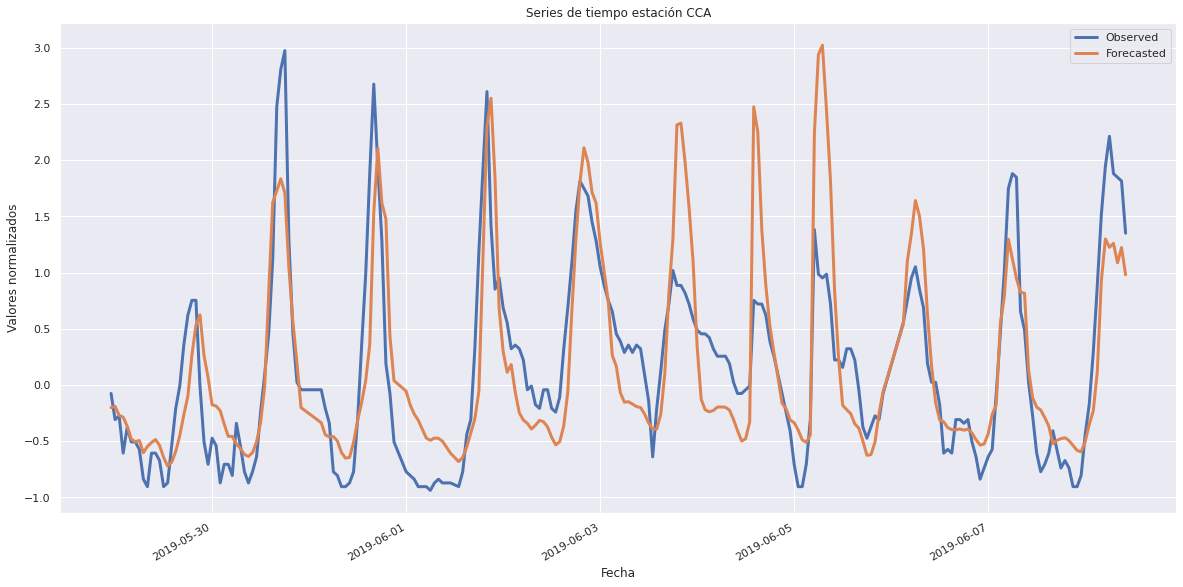

	 Done! Elapsed time 2.23 seg


In [154]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Convertir las fechas en formato de texto a objetos datetime
dates = pd.to_datetime(data.index[::])

# *********** Iterates over each case *********
t0 = time.time()
# -------------------- Reading data -------------
output_nn_all = model.predict(X, verbose=1)
try:
    # Plotting some intermediate results
    size = 24 * 10  # Two months of data
    start = np.random.randint(0, len(data) - size) #4141+ (14*24)
    end = start + size
    plt.figure(figsize=[20, 10])
    
    # Limitar el rango de datos a graficar
    plot_this_many = 24 * 10
    plot_range = slice(start, start + plot_this_many)
    
    # Graficar los datos utilizando las fechas como índice en el eje x
    plt.plot(dates[plot_range], Y[plot_range], linewidth=3.0, label='Observed')
    plt.plot(dates[plot_range], output_nn_all[plot_range, 0], linewidth=3.0, label='Forecasted')
    
    factor_wind = 0.9
    #plt.plot(dates[plot_range], factor_wind*U10_0_h0_column[plot_range], linestyle='--', label='U10_0_h0_column')
    #plt.plot(dates[plot_range], factor_wind*V10_0_h0_column[plot_range], linestyle='--', label='V10_0_h0_column')
    #plt.plot(x_plot[0:plot_this_many], factor_wind * wind_abs[0:plot_this_many], linestyle='--', label='Wind Abs')
    #plt.plot(dates[plot_range], factor_wind*wind_abs[plot_range], linestyle='--', label='Wind Abs')
    
    factor_rain = 10
    #plt.plot(dates[plot_range], factor_rain*RAIN_0_h0_column[plot_range], linestyle='-', label='RAIN_0_h0_column')
    #plt.plot(dates[plot_range], factor_rain*RAINNC_0_h0_column[plot_range], linestyle='-', label='RAINNC_0_h0_column')
    
    factor_swdown = 1
    #plt.plot(dates[plot_range], factor_swdown*SWDOWN_0_h0_column[plot_range], linestyle=':', label='SWDOWN_0_h0_column')
    
    factor_glw = 1
    #plt.plot(dates[plot_range], factor_glw*GLW_0_h0_column[plot_range], linestyle=':', label='GLW_0_h0_column')
    
    plt.legend()
    
    # Personalizar el gráfico
    plt.xlabel('Fecha')
    plt.ylabel('Valores normalizados')
    plt.title(f'Series de tiempo estación {cur_station}')
    
    # Personalizar las fechas en el eje x
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Intervalo de días entre las marcas principales
    ax.xaxis.set_minor_locator(mdates.DayLocator())  # Marcas menores para cada día
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato de las marcas principales
    plt.gcf().autofmt_xdate()
    
    # Mostrar el gráfico
    plt.show()
    
    print(F'\t Done! Elapsed time {time.time() - t0:0.2f} seg')
except:
    print('no fue bien, probablemente no estan fechas')

In [155]:
start

3407

### Desnormalización:

In [156]:
# Obtener la media y la desviación estándar estimada para cada característica
mean = scaler.mean_
std = scaler.scale_

# Imprimir la descripción
print("Media de cada característica:")
print(mean[-1])
print("Desviación estándar estimada de cada característica:")
print(std[-1])

Media de cada característica:
31.282587064676616
Desviación estándar estimada de cada característica:
30.15982853437353


 15/240 [>.............................] - ETA: 0s 

2023-05-15 16:03:24.971083: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_175191"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3915"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

240/240 [==============================] - 1s 5ms/step


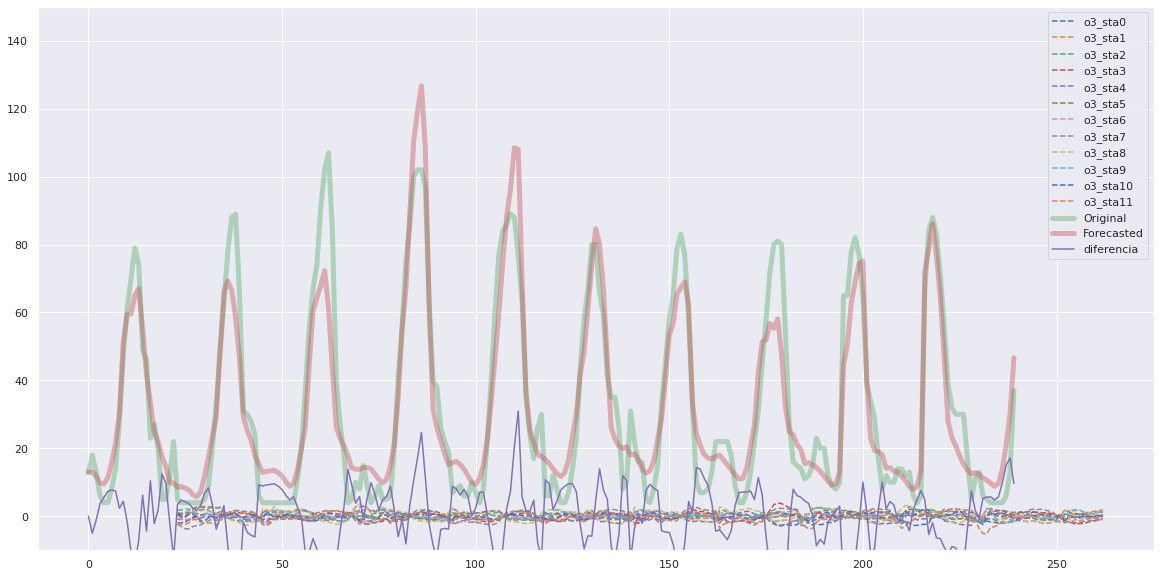

	 Done! Elapsed time 2.22 seg
Gráfica de 12 estaciones contaminantes + 23h


In [157]:

# Desnormalización:
t0 = time.time()
# -------------------- Reading data -------------
output_nn_all = model.predict(X, verbose=1)
yy_plot = output_nn_all
yy_plot = (yy_plot * std[-1]) + mean[-1]

# Plotting some intermediate results
import matplotlib.pyplot as plt
size = 24 * 10  # Two months of data
start = np.random.randint(0, len(data) - size)
end = start + size
#plt.figure(figsize=[64, 8])
plt.figure(figsize=[20, 10])
x_plot = range(len(Y))
y_plot = (Y * std[-1]) + mean[-1]

# Crear una lista vacía para almacenar las columnas desnormalizadas
o3_columns_denorm = []

# Desnormalizar las columnas de las estaciones 0 a 11
for i, o3_column in enumerate(o3_columns):
    idx = idx_sta0 + i
    o3_column_denorm = (o3_column * std[idx] + mean[idx])
    o3_columns_denorm.append(o3_column_denorm)

dife = yy_plot.squeeze() - y_plot
plot_this_many= 24*10

# Asumiendo que 'o3_columns_denorm' contiene las columnas desnormalizadas de las estaciones
for i, o3_column_denorm in enumerate(o3_columns_denorm):
    plt.plot(x_plot[23:plot_this_many+23], o3_column_denorm[:plot_this_many], linestyle='--', label=f'o3_sta{i}')


plt.plot(x_plot[0:plot_this_many], y_plot[0:plot_this_many], linewidth=5.0,label='Original',alpha=0.4)
plt.plot(x_plot[0:plot_this_many], yy_plot[0:plot_this_many,0], linewidth=5.0, label='Forecasted',alpha=0.4)
plt.plot(x_plot[0:plot_this_many], dife[0:plot_this_many], label='diferencia')


#plt.plot(x_plot[start:start + plot_this_many], y_plot[start:start + plot_this_many], label='Original')
#plt.plot(x_plot[start:start + plot_this_many], yy_plot[start:start + plot_this_many,0], label='Forecasted')

# Restringir el eje Y a [-10, 150]
plt.ylim(-10, 150)

plt.legend()
plt.show()

print(F'''\t Done! Elapsed time {time.time() - t0:0.2f} seg
Gráfica de {num_stations} estaciones contaminantes + 23h''')

#### Gráficas para reporte

 15/240 [>.............................] - ETA: 0s 

2023-05-15 16:03:29.158560: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_176332"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3942"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

240/240 [==============================] - 1s 5ms/step


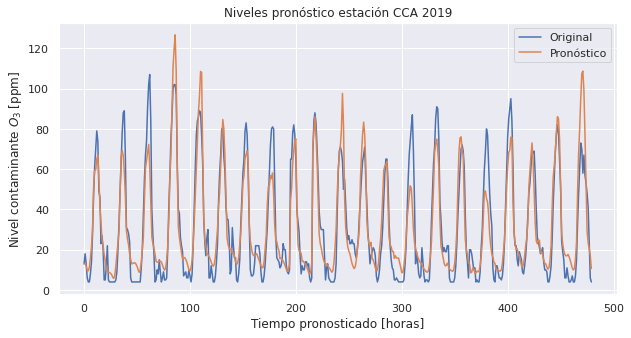

	 Done! Elapsed time 2.04 seg


In [158]:

# Desnormalización:
t0 = time.time()
# -------------------- Reading data -------------
output_nn_all = model.predict(X, verbose=1)
yy_plot = output_nn_all
yy_plot = (yy_plot * std[-1]) + mean[-1]

# Plotting some intermediate results
import matplotlib.pyplot as plt
size = 24 * 10  # Two months of data
start = 0 #np.random.randint(0, len(data) - size)
end = start + size
#plt.figure(figsize=[64, 8])
plt.figure(figsize=[10, 5])
x_plot = range(len(Y))
y_plot = (Y * std[-1]) + mean[-1]

dife = yy_plot.squeeze() - y_plot

plot_this_many= 24*20

#plt.plot(x_plot[0:plot_this_many], y_plot[0:plot_this_many], label='Original')
#plt.plot(x_plot[0:plot_this_many], yy_plot[0:plot_this_many,0], label='Forecasted')
#plt.plot(x_plot[0:plot_this_many], dife[0:plot_this_many], label='diferencia')
plt.xlabel('Tiempo pronosticado [horas]')
plt.ylabel(r'Nivel contaminante $O_3$ [ppm]')
plt.plot(x_plot[start:start + plot_this_many], y_plot[start:start + plot_this_many], label='Original')
plt.plot(x_plot[start:start + plot_this_many], yy_plot[start:start + plot_this_many,0], label='Pronóstico')
plt.title(f'Niveles pronóstico estación {cur_station} {test_year}')
plt.legend()
plt.show()

print(F'\t Done! Elapsed time {time.time() - t0:0.2f} seg')

### Métricas:
#### Índice de correlación, MAE, MAPE, MSE, RMSE, R2
Índice de correlación: \rho_xy = Cov_xy / \sigma_x \sigma_y

In [ ]:
print(f"Métricas estación {cur_station} para el año {test_year}\n")
data = {"x": y_plot, "y": yy_plot.squeeze()}
df = pd.DataFrame(data)
df.dropna(inplace=True)
corr_coef = df["x"].corr(df["y"])
print(f"Índice de correlación:                     {corr_coef:.4f}")
sb.glue("corr_coef", corr_coef)

y_true, y_prediction = y_plot, yy_plot.squeeze()

import numpy as np

# Supongamos que y_true e y_prediction son tus vectores de etiquetas verdaderas y predicciones, respectivamente
mask = ~np.isnan(y_true) & ~np.isnan(y_prediction)
y_true = y_true[mask]
y_prediction = y_prediction[mask]


from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_prediction)
print(f"Error medio absoluto (MAE):                {mae:.4f}")
sb.glue("mae", mae)
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_true, y_prediction)
print(f"Porcentaje de error medio absoluto (MAPE): {mape:.2f}%")
sb.glue("mape", mape)
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_prediction)
print(f"Error cuadrático promedio (MSE):           {mse:.4f}")
sb.glue("mse", mse)

import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_prediction))
print(f"Raíz del error cuadrático promedio (RMSE): {rmse:.4f} ppm")
sb.glue("rmse", rmse)

from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_prediction)
print(f"Coeficiente de determinación (R2):         {r2:.4f}")
sb.glue("r2", r2)


# Datos grafico
observed, predicted = y_true, y_prediction

# Calcular la pendiente y la intercepción de la línea de ajuste
slope, intercept = np.polyfit(observed, predicted, 1)

# Crear el scatter plot
size = 7
fig, ax = plt.subplots(figsize=(size, size))

ax.scatter(observed, predicted, s=5, marker='+')

# Añadir la línea de ajuste al gráfico
#ax.plot(observed, slope*observed + intercept, color='red')
ax.plot(observed, slope*observed + intercept, color='red', linewidth=4, alpha=0.7, label='Ajuste lineal')
#ax.plot(observed, observed , color='blue', linewidth=4, alpha=0.7, label='Ideal')


# Imprimir la pendiente y la intercepción de la línea de ajuste
#print("Pendiente:", slope)
#print("Intercepción:", intercept)

# Añadir la ecuación de la recta al gráfico
eqn = f"""Estación: {cur_station} {test_year}
Pronosticado = {slope:.2f}*Observado + {intercept:.2f}
RMSE: {rmse:.2f} ppm
N: {len(y_true)}"""
sb.glue("slope", slope)
sb.glue("intercept", intercept)
ax.text(0.1, 0.8, eqn, transform=ax.transAxes, fontsize=12)

# Establecer los ejes X e Y con el mismo rango de unidades
max_val = 200 #max(np.max(observed), np.max(predicted))
ax.set_xlim([0, max_val])
ax.set_ylim([0, max_val])

# Etiquetas de los ejes y título del gráfico
ax.set_xlabel(r'Nivel contaminante $O_3$ observado [ppm]')
#plt.ylabel(r'Nivel contaminante $O_3$ [ppm]')
ax.set_ylabel(r'Nivel contaminante $O_3$ pronosticado [ppm]')
#ax.set_ylabel('Valores Pronosticados')

#ax.set_title(f'Scatter Plot de Correlación con Ajuste Lineal estacion {cur_station}')
print('\n')
#print(f'''Scatter Plot de estacion {cur_station} {test_year}''')

# Agregar la leyenda
#ax.legend()

# Mostrar el gráfico
plt.show()


Métricas estación CCA para el año 2019

Índice de correlación:                     0.8451
Error medio absoluto (MAE):                11.2847
Porcentaje de error medio absoluto (MAPE): 0.54%
Error cuadrático promedio (MSE):           242.5278
Raíz del error cuadrático promedio (RMSE): 15.5733 ppm
Coeficiente de determinación (R2):         0.6882


/tmp/ipykernel_2864423/3808772253.py:78: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(hb, ax=ax)


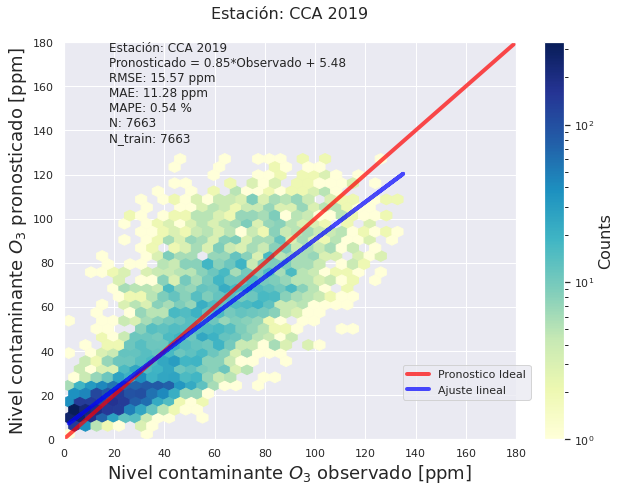

In [159]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

print(f"Métricas estación {cur_station} para el año {test_year}\n")
data = {"x": y_plot, "y": yy_plot.squeeze()}
df = pd.DataFrame(data)
df.dropna(inplace=True)
corr_coef = df["x"].corr(df["y"])
print(f"Índice de correlación:                     {corr_coef:.4f}")

y_true, y_prediction = y_plot, yy_plot.squeeze()

import numpy as np

# Supongamos que y_true e y_prediction son tus vectores de etiquetas verdaderas y predicciones, respectivamente
mask = ~np.isnan(y_true) & ~np.isnan(y_prediction)
y_true = y_true[mask]
y_prediction = y_prediction[mask]


from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_prediction)
print(f"Error medio absoluto (MAE):                {mae:.4f}")

from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_true, y_prediction)
print(f"Porcentaje de error medio absoluto (MAPE): {mape:.2f}%")

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_prediction)
print(f"Error cuadrático promedio (MSE):           {mse:.4f}")

import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_prediction))
print(f"Raíz del error cuadrático promedio (RMSE): {rmse:.4f} ppm")

from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_prediction)
print(f"Coeficiente de determinación (R2):         {r2:.4f}")


# Usar los datos observados y pronosticados en lugar de generar números aleatorios
observed = np.array(observed)
predicted = np.array(predicted)

# Calcular las métricas
mask = ~np.isnan(observed) & ~np.isnan(predicted)
observed = observed[mask]
predicted = predicted[mask]
mae = mean_absolute_error(observed, predicted)
mape = mean_absolute_percentage_error(observed, predicted)
mse = mean_squared_error(observed, predicted)
rmse = np.sqrt(mse)
r2 = r2_score(observed, predicted)
slope, intercept = np.polyfit(observed, predicted, 1)

# Definir el tamaño de los bins de hexágono
gridsize = 30

# Graficar el hexbin usando Matplotlib
sns.set()
fig, ax = plt.subplots(figsize=(9, 7))

# Establecer los ejes X e Y con el mismo rango de unidades
max_val = 180 
ax.set_xlim([0, max_val])
ax.set_ylim([0, max_val])

hb = ax.hexbin(observed, predicted, gridsize=gridsize, cmap="YlGnBu", norm=LogNorm(), mincnt=1)
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Counts', fontsize=16)

# Agregar la línea 1 a 1 y la línea de ajuste al gráfico
ax.plot(range(0,max_val), range(0,max_val), color='red', linewidth=4, alpha=0.7, label='Pronostico Ideal')
ax.plot(observed, slope * observed + intercept, color='blue', linewidth=4, alpha=0.7, label='Ajuste lineal')

# Etiquetas de los ejes y título del gráfico
ax.set_xlabel(r'Nivel contaminante observado $O_3$ ppb', fontsize=18)
ax.set_ylabel(r'Nivel contaminante pronosticado $O_3$ ppb', fontsize=18)
plt.title(f"Estación: {cur_station} {test_year}\n", fontsize=16)

# Añadir la ecuación de la recta al gráfico
eqn = f"""Estación: {cur_station} {test_year}
Índice de correlación: {corr_coef:.4f}
RMSE: {rmse:.2f} ppb
N_train: {dataN4train}
Pronosticado = {slope:.2f}*Observado + {intercept:.2f}
MAE: {mae:.2f} ppb
MAPE: {mape:.2f} %
N: {len(observed)}
"""
ax.text(0.1, 0.75, eqn, transform=ax.transAxes, fontsize=12)

# Agregar la leyenda
ax.legend(loc=(0.75, 0.1))
#ax.legend()

# Mostrar el gráfico
plt.tight_layout()  # Añadir padding al gráfico
plt.savefig(f'{test_str}_{test_identifier}_resultsres.png', dpi=150)
plt.show()


In [ ]:
sb.glue("N_train", dataN4train)

## Hexbin plot

/tmp/ipykernel_2864423/3047985068.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(hb, ax=ax)


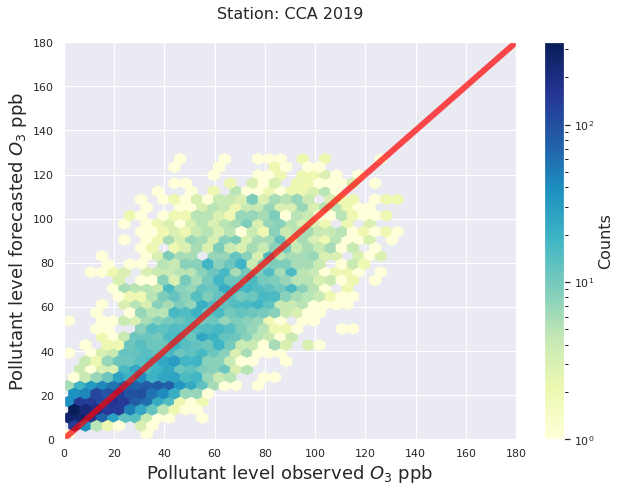

In [160]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Usar los datos observados y pronosticados en lugar de generar números aleatorios
observed = np.array(observed)
predicted = np.array(predicted)

# Definir el tamaño de los bins de hexágono
gridsize = 30  # Puedes ajustar este valor según tus preferencias

# Graficar el hexbin usando Matplotlib`
sns.set()
fig, ax = plt.subplots(figsize=(9, 7))

# Establecer los ejes X e Y con el mismo rango de unidades
max_val = 180 #max(np.max(observed), np.max(predicted))
ax.set_xlim([0, max_val])
ax.set_ylim([0, max_val])

hb = ax.hexbin(observed, predicted, gridsize=gridsize, cmap="YlGnBu", norm=LogNorm(), mincnt=1)
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Counts', fontsize=16)

# Agregar la línea 1 a 1 al gráfico
ax.plot(range(0,max_val), range(0,max_val), color='red', linewidth=6, alpha=0.7, label='Línea 1 a 1')
# linea ajuste
#ax.plot(observed, slope * observed + intercept, color='red', linewidth=4, alpha=0.7, label='Ajuste lineal')

# Etiquetas de los ejes y título del gráfico
ax.set_xlabel(r'Pollutant level observed $O_3$ ppb', fontsize=18)
ax.set_ylabel(r'Pollutant level forecasted $O_3$ ppb', fontsize=18)
plt.title(f"Station: {cur_station} {test_year}\n", fontsize=16)

# Mostrar el gráfico
plt.tight_layout()  # Añadir padding al gráfico
plt.savefig(f'{test_str}_{test_identifier}_hexbin.png', dpi=150)
plt.show()

## Metricas comparando valores promedio c/24 hrs y valores máximos c/24 hrs


In [161]:
import numpy as np

# Aquí asumimos que la longitud actual de y_true es 7020
longitud_actual = y_true.shape[0]
longitud_deseada = (longitud_actual // 24 + 1) * 24  # redondear hacia arriba para que sea divisible por 24

# Agregar ceros al final de y_true, se puede probar agregar nans, pero creo no funcionaría, quizá valores medios?
y_true = np.pad(y_true, (0, longitud_deseada - longitud_actual), mode='constant', constant_values=0)

longitud_actual = y_prediction.shape[0]

# Agregar ceros al final de y_true
y_prediction = np.pad(y_prediction, (0, longitud_deseada - longitud_actual), mode='constant', constant_values=0)

# Supongamos que y_true e y_prediction son numpy arrays de la misma longitud
# y que representan los valores observados y predichos respectivamente

# Obtener el valor máximo de cada día en y_true e y_prediction
max_y_true = np.max(np.reshape(y_true, (-1, 24)), axis=1)
max_y_pred = np.max(np.reshape(y_prediction, (-1, 24)), axis=1)

# Obtener el promedio de los valores de cada día en y_true e y_prediction
mean_y_true = np.mean(np.reshape(y_true, (-1, 24)), axis=1)
mean_y_pred = np.mean(np.reshape(y_prediction, (-1, 24)), axis=1)


### Error comparando valores maximos de cada 24 hrs (h24_max_err_mean)

Error promedio  al comparar valores máximos cada 24 hrs: -2.7871805369853973
Desviación estándard de diferencia en valores máximos diarios: 22.07145099061494


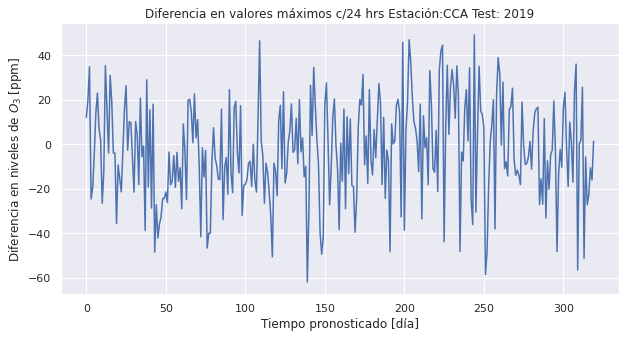

In [162]:
plt.figure(figsize=[10, 5])

plt.plot(max_y_true - max_y_pred)
h24_max_err_mean = np.mean(max_y_true - max_y_pred)
h24_max_err_std  = np.std(max_y_true - max_y_pred)
sb.glue("h24_max_err_mean", h24_max_err_mean)
sb.glue("h24_max_err_std", h24_max_err_std)

print(f'Error promedio  al comparar valores máximos cada 24 hrs: {h24_max_err_mean}')
print(f'Desviación estándard de diferencia en valores máximos diarios: {h24_max_err_std}')

plt.title(f'Diferencia en valores máximos c/24 hrs Estación:{cur_station} Test: {test_year}')
plt.xlabel('Tiempo pronosticado [día]')
plt.ylabel(r'Diferencia en niveles de $O_3$ [ppm]')
plt.show()

### Error comparando valores medios de cada 24 hrs (h24_avg_err_mean)

Error promedio al comparar valores promedio diarios -0.19866925006111452
Desviación estándard de diferencia en valores promedios diarios 6.84877956081791


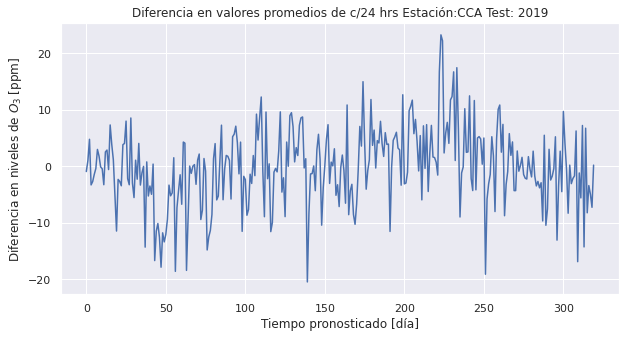

In [163]:
plt.figure(figsize=[10, 5])

plt.plot(mean_y_true - mean_y_pred)

h24_avg_err_mean = np.mean(mean_y_true - mean_y_pred)
h24_avg_err_std  = np.std(mean_y_true - mean_y_pred)
sb.glue("h24_avg_err_mean", h24_avg_err_mean)
sb.glue("h24_avg_err_std", h24_avg_err_std)


print(f'Error promedio al comparar valores promedio diarios {h24_avg_err_mean}')
print(f'Desviación estándard de diferencia en valores promedios diarios {h24_avg_err_std}')
plt.title(f'Diferencia en valores promedios de c/24 hrs Estación:{cur_station} Test: {test_year}')
plt.xlabel('Tiempo pronosticado [día]')
plt.ylabel(r'Diferencia en niveles de $O_3$ [ppm]')

plt.show()

In [164]:
max_y_true

array([ 79.,  89., 107., 102.,  89.,  80.,  83.,  81.,  82.,  88.,  71.,
        71.,  87.,  91.,  72.,  80.,  95.,  69.,  82.,  73.,  71.,  52.,
        59.,  66.,  96.,  68.,  61.,  84., 115., 113.,  98., 125., 116.,
        50.,  85.,  91., 106.,  74.,  85.,  61., 115.,  93.,  86.,  45.,
        40.,  33.,  46.,  70.,  75.,  78.,  72.,  69.,  88., 104., 103.,
       104.,  84.,  99.,  86., 105.,  83.,  94.,  85.,  86.,  95., 105.,
        94.,  61., 101.,  73.,  60.,  92.,  60.,  80.,  95., 103.,  61.,
        60.,  76., 105., 133., 120.,  78.,  90.,  63.,  99.,  70.,  68.,
       103.,  75., 135.,  96.,  71.,  84., 128., 112., 107., 121.,  93.,
       103., 105., 111.,  96.,  84.,  86., 127.,  97., 102., 114., 124.,
        96.,  86.,  89.,  95.,  78.,  71.,  66.,  62.,  97., 115.,  96.,
       117., 121., 116., 130.,  88.,  88., 116., 123., 128., 114., 109.,
       107.,  86., 110., 103., 124., 108.,  83.,  51.,  41.,  58.,  54.,
       121., 112., 110.,  86.,  62.,  73.,  63.,  8

In [165]:
max_y_pred

array([ 67.037415,  69.224525,  72.28276 , 126.70164 , 108.5066  ,
        84.65747 ,  69.06411 ,  58.09115 ,  75.103645,  86.11407 ,
        97.60479 ,  83.3636  ,  51.715614,  74.92124 ,  76.039024,
        49.16155 ,  75.935326,  73.039185,  86.076614, 108.699554,
        80.41318 ,  67.47726 ,  80.4581  ,  68.8134  ,  80.1512  ,
        41.80431 ,  63.782425,  73.97087 , 105.30583 , 118.584274,
       119.56643 , 114.89431 , 111.829765,  68.22307 ,  64.29744 ,
        96.68727 , 106.85281 , 112.805405,  56.113125,  80.27442 ,
        99.664734, 121.699646,  68.05412 ,  93.456665,  67.205765,
        75.18839 ,  81.934044, 102.74829 ,  99.44006 , 102.45202 ,
        93.493805,  95.26649 ,  91.57886 , 122.32303 , 119.63904 ,
       109.20336 , 103.42073 , 102.75609 , 102.74753 , 115.65001 ,
       112.04176 ,  84.96885 ,  87.90014 , 110.984566,  75.426544,
        84.814316,  79.438576,  60.381416,  78.50917 ,  70.18849 ,
        49.025955, 101.78001 , 101.59771 ,  81.64742 , 109.805

In [166]:
mean_y_true

array([27.20833333, 27.29166667, 33.29166667, 39.41666667, 36.66666667,
       31.91666667, 30.08333333, 30.66666667, 28.625     , 30.79166667,
       40.08333333, 32.45833333, 26.66666667, 31.25      , 29.41666667,
       28.66666667, 34.41666667, 31.75      , 30.25      , 29.625     ,
       26.70833333, 20.75      , 32.45833333, 42.95833333, 35.83333333,
       27.33333333, 27.91666667, 28.33333333, 47.16666667, 41.        ,
       36.375     , 49.25      , 45.70833333, 32.625     , 27.125     ,
       36.125     , 39.20833333, 27.875     , 23.04166667, 26.        ,
       33.125     , 37.54166667, 32.70833333, 23.41666667, 15.45833333,
       15.29166667, 16.16666667, 19.79166667, 36.20833333, 29.83333333,
       24.04166667, 28.41666667, 36.58333333, 38.91666667, 39.33333333,
       46.41666667, 21.83333333, 32.125     , 31.95833333, 41.        ,
       42.83333333, 45.        , 44.125     , 37.29166667, 23.25      ,
       36.5       , 33.75      , 27.625     , 37.29166667, 27.29

In [167]:
mean_y_pred

array([28.179285 , 26.317026 , 28.554525 , 42.753765 , 39.414036 ,
       33.394592 , 30.507032 , 27.721893 , 26.862547 , 30.937836 ,
       40.56265  , 35.761818 , 24.169474 , 28.419077 , 30.037338 ,
       21.391983 , 30.596397 , 30.659048 , 35.63948  , 41.129467 ,
       29.071167 , 23.460566 , 35.94964  , 39.174763 , 31.831825 ,
       19.376934 , 30.138962 , 31.641993 , 38.65608  , 44.009457 ,
       41.9525   , 48.211994 , 48.030975 , 28.616165 , 30.48905  ,
       37.319286 , 39.26746  , 42.225063 , 22.305841 , 31.299988 ,
       36.657104 , 42.53999  , 32.35952  , 40.14949  , 26.974588 ,
       25.460806 , 28.784891 , 37.69485  , 48.027073 , 43.25658  ,
       36.13132  , 37.839817 , 39.955746 , 44.18422  , 44.0932   ,
       44.944622 , 40.472477 , 39.50221  , 36.310688 , 42.541286 ,
       49.59755  , 40.74863  , 40.06528  , 55.759277 , 32.68224  ,
       36.50117  , 35.04245  , 27.652987 , 37.032116 , 30.524004 ,
       25.693176 , 38.24585  , 36.83537  , 33.695965 , 37.3306

In [168]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

### Usando valores máximos c/24h

In [169]:
errors = max_y_true - max_y_pred
print(errors)

[ 1.19625854e+01  1.97754745e+01  3.47172394e+01 -2.47016373e+01
 -1.95065994e+01 -4.65747070e+00  1.39358902e+01  2.29088516e+01
  6.89635468e+00  1.88593292e+00 -2.66047897e+01 -1.23636017e+01
  3.52843857e+01  1.60787582e+01 -4.03902435e+00  3.08384514e+01
  1.90646744e+01 -4.03918457e+00 -4.07661438e+00 -3.56995544e+01
 -9.41317749e+00 -1.54772568e+01 -2.14580994e+01 -2.81340027e+00
  1.58488007e+01  2.61956902e+01 -2.78242493e+00  1.00291290e+01
  9.69416809e+00 -5.58427429e+00 -2.15664291e+01  1.01056900e+01
  4.17023468e+00 -1.82230682e+01  2.07025604e+01 -5.68727112e+00
 -8.52813721e-01 -3.88054047e+01  2.88868752e+01 -1.92744217e+01
  1.53352661e+01 -2.86996460e+01  1.79458771e+01 -4.84566650e+01
 -2.72057648e+01 -4.21883926e+01 -3.59340439e+01 -3.27482910e+01
 -2.44400635e+01 -2.44520187e+01 -2.14938049e+01 -2.62664871e+01
 -3.57885742e+00 -1.83230286e+01 -1.66390381e+01 -5.20336151e+00
 -1.94207306e+01 -3.75608826e+00 -1.67475281e+01 -1.06500092e+01
 -2.90417633e+01  9.03115

In [170]:
# Confidence level:
confidence_level = 70

#--------------------

lower_percentile = (100 - confidence_level) / 2
upper_percentile = 100 - lower_percentile

lower_error = np.percentile(errors, lower_percentile)
upper_error = np.percentile(errors, upper_percentile)


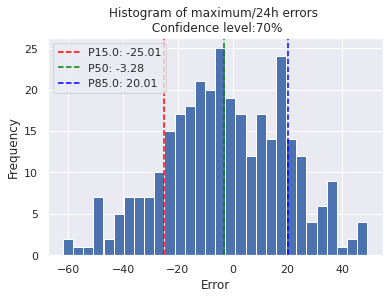

In [171]:
# Plot errors y confidence levels

# Calcular los percentiles de interés
percentiles = [lower_percentile, 50, upper_percentile]
percentile_values = np.percentile(errors, percentiles)

# Crear el histograma
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title(F'Histogram of maximum/24h errors \n Confidence level:{confidence_level}%')

# Añadir líneas verticales para los percentiles
colors = ['red', 'green', 'blue']
for i, value in enumerate(percentile_values):
    plt.axvline(value, color=colors[i], linestyle='--', label=f"P{percentiles[i]}: {value:.2f}")

# Añadir leyenda
plt.legend()
plt.show()


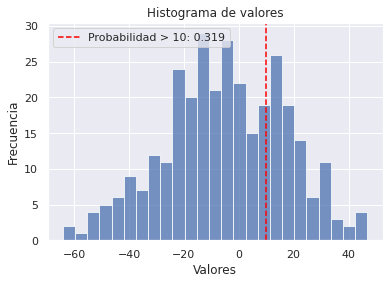

In [172]:
# Tus datos originales
datos = errors

# Elegir el número de bins
numero_bins = 25

# Calcular el mínimo y máximo de tus datos
minimo_datos = np.min(datos)
maximo_datos = np.max(datos)

# Calcular el ancho de cada bin
ancho_bin = (maximo_datos - minimo_datos) / numero_bins

# Crear los límites de los bins
bins = np.arange(minimo_datos, maximo_datos + ancho_bin, ancho_bin)

# Calcular el histograma usando los bins
histograma, _ = np.histogram(datos, bins=bins)

# Contar el número total de elementos en tus datos
total_elementos = len(datos)

# Filtrar los datos mayores a 10
datos_mayores_10 = datos[datos > 10]

# Contar cuántos valores son mayores a 10
cantidad_mayores_10 = len(datos_mayores_10)

# Calcular la probabilidad de que un valor sea mayor a 10
probabilidad_mayor_10 = cantidad_mayores_10 / total_elementos

# Crear un gráfico de barras para el histograma
plt.bar(bins[:-1], histograma, width=ancho_bin, alpha=0.75)
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de valores')

# Dibujar una línea vertical en x=10 para mostrar la probabilidad
plt.axvline(x=10, color='red', linestyle='--', label=f'Probabilidad > 10: {probabilidad_mayor_10:.3f}')
plt.legend()

# Mostrar el gráfico
plt.show()

Considerando que los errores son representativos en general para los valores pronósticados, se estiman probabilidades a partir de distribución de errores

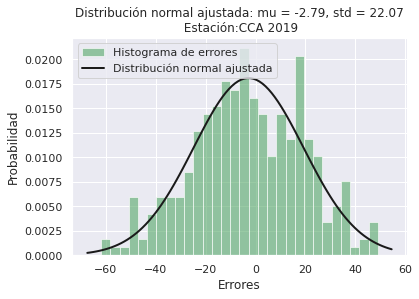

In [173]:
# Genera datos de errores simulados
errores = errors

# Ajusta una distribución normal a los datos de errores
mu, std = norm.fit(errores)

sb.glue("h24_maxd_mu", mu)
sb.glue("h24_maxd_std", std)

# Histograma de los errores
plt.hist(errores, bins=30, density=True, alpha=0.6, color='g', label="Histograma de errores")

# Genera la PDF de la distribución normal ajustada
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Grafica la PDF de la distribución normal ajustada
plt.plot(x, p, 'k', linewidth=2, label="Distribución normal ajustada")
plt.xlabel('Errores')
plt.ylabel('Probabilidad')
plt.title(f"Distribución normal ajustada: mu = {mu:.2f}, std = {std:.2f}\n Estación:{cur_station} {test_year}")
plt.legend()
plt.savefig(f'{test_str}_{test_identifier}_error_dist_plot.png', dpi=150)

plt.show()



In [174]:
print(mu)
print(std)

-2.7871805369853973
22.07145099061494


## Probabilidad de superar umbral de 90 ppb de ozono, con base en los errores de máximos c/24hrs.

In [175]:
# Valores de pronóstico de contaminantes
pronosticos = [50,60,70,80,90,100,120,140,150]

# Umbral de contaminantes
umbral = 90

# Calcular e imprimir las probabilidades de cada caso
for pronostico in pronosticos:
    error_necesario = umbral - pronostico
    probabilidad = norm.cdf(error_necesario, loc=mu, scale=std)
    print(f"La probabilidad de exceder umbral de {umbral} ppb(s) con pronóstico de {pronostico} ppb es del {(1 - probabilidad)*100:.2f}%")

La probabilidad de exceder umbral de 90 ppb(s) con pronóstico de 50 ppb es del 2.63%
La probabilidad de exceder umbral de 90 ppb(s) con pronóstico de 60 ppb es del 6.87%
La probabilidad de exceder umbral de 90 ppb(s) con pronóstico de 70 ppb es del 15.09%
La probabilidad de exceder umbral de 90 ppb(s) con pronóstico de 80 ppb es del 28.12%
La probabilidad de exceder umbral de 90 ppb(s) con pronóstico de 90 ppb es del 44.98%
La probabilidad de exceder umbral de 90 ppb(s) con pronóstico de 100 ppb es del 62.81%
La probabilidad de exceder umbral de 90 ppb(s) con pronóstico de 120 ppb es del 89.12%
La probabilidad de exceder umbral de 90 ppb(s) con pronóstico de 140 ppb es del 98.38%
La probabilidad de exceder umbral de 90 ppb(s) con pronóstico de 150 ppb es del 99.52%
